<a href="https://colab.research.google.com/github/alaa-fradi/Fraudulent-transaction-prediction-model/blob/main/Approach_Profile_V_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Building Model Approach 1:**

# Initialisation

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from sklearn import preprocessing

import scikitplot as skplt
from sklearn.metrics import balanced_accuracy_score
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import io
from google.colab import files

import math 
import re
import missingno as msno
# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis , QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# Data Preprocessing 

## Part 1 

### Uploading Data

In [ ]:
uploaded = files.upload() #Retour_fraud.xlsx 

Saving Retour_fraude.xlsx to Retour_fraude.xlsx


In [ ]:
dataOPD = pd.read_excel(io.BytesIO(uploaded['Retour_fraude.xlsx']), sheet_name='OPD')

### Resetting Data

In [ ]:
dfOPD=dataOPD.copy(deep=True)



---



---



In [ ]:
dfOPD['Institution intermédiaire']

0        54
1        54
3        54
4        54
5        54
         ..
50631     8
50632    11
50633    54
50634    54
50635    54
Name: Institution intermédiaire, Length: 47950, dtype: int64

In [ ]:
dfOPD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47950 entries, 0 to 50635
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Référence transaction      47950 non-null  int64         
 1   DATE_TRANSACTION           47950 non-null  datetime64[ns]
 2   TYPE_TRANSACTION           47950 non-null  object        
 3   RIB origine                47950 non-null  int64         
 4   Rib bénéficiaire           47775 non-null  float64       
 5   BANQUE BéNéFICIAIRE        47950 non-null  int64         
 6   Institution intermédiaire  47950 non-null  int64         
 7   Montant                    47950 non-null  float64       
 8   Devise                     47950 non-null  int64         
 9   CA 2020                    40059 non-null  float64       
 10  Categorie                  47950 non-null  object        
 11  Tranche_Age                47387 non-null  object        
 12  Tran

### Type Correction (Montant and DateTransaction)

Correcting Type Montant and DateTransaction:

In [ ]:
#convertir la colonne Montant en flot
#remplacer "," par "."
def replacee(s):
    i=str(s).find(',')
    if(i>0):
        return s[:i] + '.' + s[i+1:]
    else :
        return s 

dfOPD['Montant']=dfOPD['Montant'].apply(replacee)
dfOPD['Montant'] = pd.to_numeric(dfOPD['Montant'], errors='coerce')

dfOPD['DATE_TRANSACTION']= pd.to_datetime(dfOPD['DATE_TRANSACTION'])




---



---



### Delete columns containing either 75% or more than 75% NaN Values

In [ ]:
perc = 75.0
min_count =  int(((100-perc)/100)*dfOPD.shape[0] + 1)
dfOPD = dfOPD.dropna( axis=1, 
                thresh=min_count)

In [ ]:
dfOPD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50636 entries, 0 to 50635
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Référence transaction      50636 non-null  int64         
 1   DATE_TRANSACTION           50636 non-null  datetime64[ns]
 2   TYPE_TRANSACTION           50636 non-null  object        
 3   RIB origine                50636 non-null  int64         
 4   Rib bénéficiaire           50455 non-null  float64       
 5   BANQUE BéNéFICIAIRE        50636 non-null  int64         
 6   Institution intermédiaire  50636 non-null  int64         
 7   Montant                    50636 non-null  float64       
 8   Devise                     50636 non-null  int64         
 9   CA 2020                    41471 non-null  float64       
 10  Categorie                  50632 non-null  object        
 11  Tranche_Age                48393 non-null  object        
 12  Tran



---



### Risk Column

In [ ]:
#eliminating rows with Risk = null 
dfOPD.dropna(subset=['Niveau_Risque_LAB_FT'], inplace=True)


### Train Test Split by Rib Origin AND Category : 

the idea is to prevent that transactions from the same user will not be found in train and test 

we are going to split a data set containing unique Rib Origine == split USERS 

then, we will add to train and test data the rest of trasactions for each user 

In [ ]:
df=dfOPD.copy(deep=True)

In [ ]:
df['Niveau_Risque_LAB_FT'].value_counts()

Low              28076
Moderate         12828
High              5439
ExtremelyHigh     1607
Name: Niveau_Risque_LAB_FT, dtype: int64

Create Column Count

In [ ]:
ROCount=df['RIB origine'].value_counts() #a
dfROCount=ROCount.to_frame().reset_index().rename(columns={'RIB origine':'Count','index':'RIB origine' }) #dfA
dfOPDC = pd.merge(dfROCount, df, on=['RIB origine']) #dfJoin
dfOPDC

,RIB origine,Count,Référence transaction,DATE_TRANSACTION,TYPE_TRANSACTION,Rib bénéficiaire,BANQUE BéNéFICIAIRE,Institution intermédiaire,Montant,Devise,...,Tranche_Age,Tranche_Anciennete,Secteur_Activite,Politiquement_Expose,Niveau_Risque_LAB_FT,Code_Nationalite,CodePostal,Delegation,Ville,Region
0,18492,1239,2588,2020-04-02,OPF,24903.0,1452,54,195000.00,978,...,Tranche sup 25,Tranche sup à 20,TRANSPORTS ET ENTREPOSAGE,0.0,Low,TN,1001 ...,BAB EL BHAR,TUNIS REPUBLIQUE,NORD-EST
1,18492,1239,2871,2020-04-02,OPF,24793.0,1451,54,192000.00,978,...,Tranche sup 25,Tranche sup à 20,TRANSPORTS ET ENTREPOSAGE,0.0,Low,TN,1001 ...,BAB EL BHAR,TUNIS REPUBLIQUE,NORD-EST
2,18492,1239,69828,2020-12-23,OPF,12002.0,1017,1,4776.34,978,...,Tranche sup 25,Tranche sup à 20,TRANSPORTS ET ENTREPOSAGE,0.0,Low,TN,1001 ...,BAB EL BHAR,TUNIS REPUBLIQUE,NORD-EST
3,18492,1239,71000,2019-05-10,OPF,11643.0,1306,20,5500.00,978,...,Tranche sup 25,Tranche sup à 20,TRANSPORTS ET ENTREPOSAGE,0.0,Low,TN,1001 ...,BAB EL BHAR,TUNIS REPUBLIQUE,NORD-EST
4,18492,1239,71002,2019-05-10,OPF,11643.0,1306,20,9556.60,978,...,Tranche sup 25,Tranche sup à 20,TRANSPORTS ET ENTREPOSAGE,0.0,Low,TN,1001 ...,BAB EL BHAR,TUNIS REPUBLIQUE,NORD-EST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47945,17755,1,103535,2019-10-04,OPF,3280.0,323,7,5000.00,840,...,Tranche 36 - 50,Tranche 2 - 3,NaN,0.0,Moderate,DZ,NaN,NaN,NaN,NaN
47946,15708,1,103202,2021-03-04,OPC,3366.0,95,10,16513.84,840,...,Tranche 51 - 60,Tranche sup à 20,NaN,0.0,High,TN,8011 ...,DAR CHAABANE EL FEHRI,DAR CHABANE EL FEHR,NORD-EST
47947,19279,1,102534,2019-12-23,OPC,3489.0,1321,25,5245.00,978,...,Tranche sup 25,Tranche sup à 20,COMMERCE; REPARATION D'AUTOMOBILES ET DE MOTOC...,0.0,Low,TN,4000 ...,SOUSSE VILLE,SOUSSE,CENTRE-EST
47948,18179,1,110716,2019-02-18,OPF,1273.0,1441,54,3000.00,978,...,Tranche 8 - 15,Tranche 11 - 20,COMMERCE; REPARATION D'AUTOMOBILES ET DE MOTOC...,0.0,Low,IT,2086 ...,MANOUBA,DAOUR HICHER,NORD-EST


df with Unique Rib Origine

In [ ]:
#List Unique RO 
ListROUnique = pd.unique(dfOPDC['RIB origine'])
# df with RO unique
dfROUnique = pd.DataFrame()
for i in ListROUnique : #L = List des RO unique 
  dfROUnique=dfROUnique.append(dfOPDC[dfOPDC['RIB origine']==i].iloc[0],ignore_index=True)

dfROUnique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3698 entries, 0 to 3697
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   RIB origine                3698 non-null   float64       
 1   Count                      3698 non-null   float64       
 2   Référence transaction      3698 non-null   float64       
 3   DATE_TRANSACTION           3698 non-null   datetime64[ns]
 4   TYPE_TRANSACTION           3698 non-null   object        
 5   Rib bénéficiaire           3674 non-null   float64       
 6   BANQUE BéNéFICIAIRE        3698 non-null   float64       
 7   Institution intermédiaire  3698 non-null   float64       
 8   Montant                    3698 non-null   float64       
 9   Devise                     3698 non-null   float64       
 10  CA 2020                    2348 non-null   float64       
 11  Categorie                  3698 non-null   object        
 12  Tranch

In [ ]:
Cat = dfROUnique['Categorie']



---



---



In [ ]:
dfROUnique['CA 2020'].value_counts()

28.850         21
43.270         14
73.010          7
51.830          7
1000.000        6
               ..
26009.000       1
22491.980       1
3192780.145     1
40697.621       1
47538.417       1
Name: CA 2020, Length: 2270, dtype: int64

In [ ]:
tt=dfROUnique.copy(deep=True)

In [ ]:
tt['CA_Band'] = pd.qcut(tt['CA 2020'], 14)
tt[['CA_Band', 'Niveau_Risque_LAB_FT']].groupby(['CA_Band'], as_index=False).mean().sort_values(by='CA_Band', ascending=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CA_Band
0,"(-490752.296, 1162.824]"
1,"(1162.824, 4287.974]"
2,"(4287.974, 11736.512]"
3,"(11736.512, 32482.399]"
4,"(32482.399, 70608.786]"
5,"(70608.786, 134996.017]"
6,"(134996.017, 237085.88]"
7,"(237085.88, 421917.596]"
8,"(421917.596, 669707.158]"
9,"(669707.158, 1114471.591]"




---



In [ ]:
dfROUnique['Categorie'].value_counts()

Personne morale                               2140
Personne physique                             1463
Associations, Partis, Syndics et Syndicats      37
Organismes                                      29
Ambassades                                      16
Autres institutions sans but lucratif            9
Autres institutions                              2
Liste Campagne Electorale                        2
Name: Categorie, dtype: int64

In [ ]:
dfROUnique['Niveau_Risque_LAB_FT'].value_counts()

Low              2235
Moderate          794
High              511
ExtremelyHigh     158
Name: Niveau_Risque_LAB_FT, dtype: int64

In [ ]:
Ftrain, Ftest = train_test_split(dfROUnique, test_size=0.2, random_state=1,stratify=Cat)

In [ ]:
Ftrain['Niveau_Risque_LAB_FT'].value_counts()

Low              1823
Moderate          626
High              386
ExtremelyHigh     123
Name: Niveau_Risque_LAB_FT, dtype: int64

In [ ]:
#output FTrain to csv file to do analysis :
#from google.colab import files
#Ftrain.to_csv('Ftrain.csv') 
#files.download('Ftrain.csv')

In [ ]:
Ftest['Niveau_Risque_LAB_FT'].value_counts()

Low              412
Moderate         168
High             125
ExtremelyHigh     35
Name: Niveau_Risque_LAB_FT, dtype: int64

In [ ]:
Ftrain['Categorie'].value_counts()

Personne morale                               1712
Personne physique                             1170
Associations, Partis, Syndics et Syndicats      29
Organismes                                      23
Ambassades                                      13
Autres institutions sans but lucratif            7
Autres institutions                              2
Liste Campagne Electorale                        2
Name: Categorie, dtype: int64

In [ ]:
Ftest['Categorie'].value_counts()

Personne morale                               428
Personne physique                             293
Associations, Partis, Syndics et Syndicats      8
Organismes                                      6
Ambassades                                      3
Autres institutions sans but lucratif           2
Name: Categorie, dtype: int64

In [ ]:
Ftest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 740 entries, 2318 to 1197
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   RIB origine                740 non-null    float64       
 1   Count                      740 non-null    float64       
 2   Référence transaction      740 non-null    float64       
 3   DATE_TRANSACTION           740 non-null    datetime64[ns]
 4   TYPE_TRANSACTION           740 non-null    object        
 5   Rib bénéficiaire           733 non-null    float64       
 6   BANQUE BéNéFICIAIRE        740 non-null    float64       
 7   Institution intermédiaire  740 non-null    float64       
 8   Montant                    740 non-null    float64       
 9   Devise                     740 non-null    float64       
 10  CA 2020                    469 non-null    float64       
 11  Categorie                  740 non-null    object        
 12  Tran



---



In [ ]:
FFtrain=dfOPDC[dfOPDC['RIB origine'].isin(Ftrain['RIB origine'])]
FFtest=dfOPDC[dfOPDC['RIB origine'].isin(Ftest['RIB origine'])]

In [ ]:
FFtrain['Niveau_Risque_LAB_FT'].value_counts()

Low              23874
Moderate         11088
High              4225
ExtremelyHigh     1069
Name: Niveau_Risque_LAB_FT, dtype: int64

In [ ]:
train=FFtrain.copy(deep=True)
test=FFtest.copy(deep=True)



---



In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40256 entries, 0 to 47949
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   RIB origine                40256 non-null  int64         
 1   Count                      40256 non-null  int64         
 2   Référence transaction      40256 non-null  int64         
 3   DATE_TRANSACTION           40256 non-null  datetime64[ns]
 4   TYPE_TRANSACTION           40256 non-null  object        
 5   Rib bénéficiaire           40102 non-null  float64       
 6   BANQUE BéNéFICIAIRE        40256 non-null  int64         
 7   Institution intermédiaire  40256 non-null  int64         
 8   Montant                    40256 non-null  float64       
 9   Devise                     40256 non-null  int64         
 10  CA 2020                    34082 non-null  float64       
 11  Categorie                  40256 non-null  object        
 12  Tran

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7694 entries, 7960 to 47947
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   RIB origine                7694 non-null   int64         
 1   Count                      7694 non-null   int64         
 2   Référence transaction      7694 non-null   int64         
 3   DATE_TRANSACTION           7694 non-null   datetime64[ns]
 4   TYPE_TRANSACTION           7694 non-null   object        
 5   Rib bénéficiaire           7673 non-null   float64       
 6   BANQUE BéNéFICIAIRE        7694 non-null   int64         
 7   Institution intermédiaire  7694 non-null   int64         
 8   Montant                    7694 non-null   float64       
 9   Devise                     7694 non-null   int64         
 10  CA 2020                    5977 non-null   float64       
 11  Categorie                  7694 non-null   object        
 12  Tr

###### Visualization :

Text(0, 0.5, 'Number of customers')

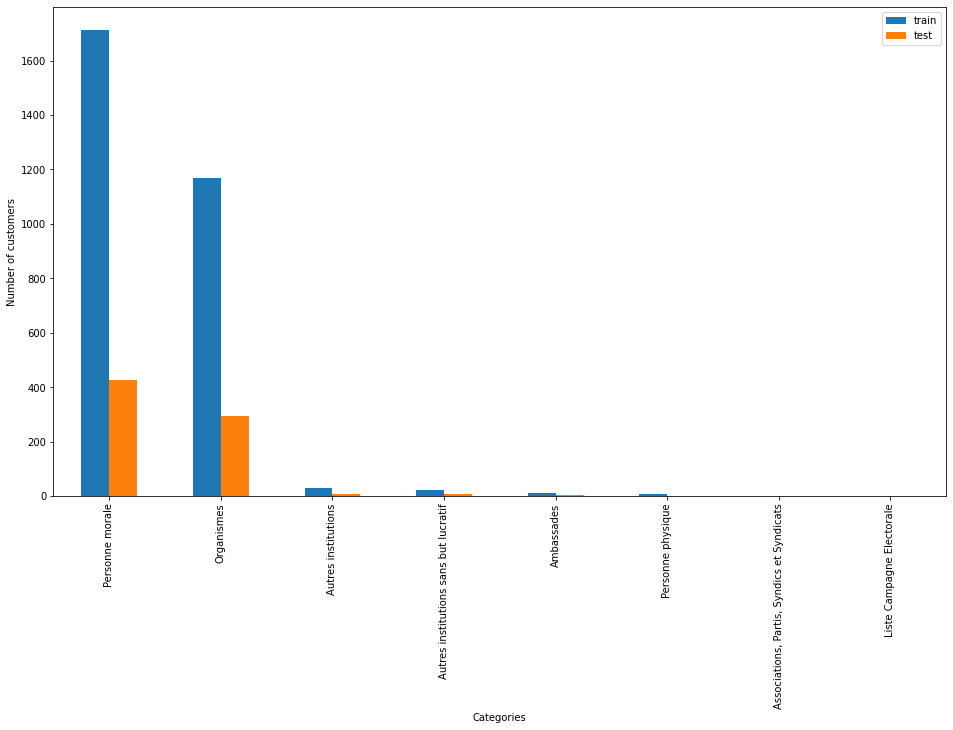

In [ ]:
VCTrain = list(Ftrain['Categorie'].value_counts())
CVTest = list(Ftest['Categorie'].value_counts())
# dataset is splitted 80/20 so the low categories will be given entirely to train == the length of CVTest and CVTrain not the same = error => appended 0 to CVTest
CVTest.extend([0]* (len(list(Ftrain['Categorie'].value_counts())) - len(list(Ftest['Categorie'].value_counts()))))

P = pd.DataFrame({ 'Categories':dfROUnique['Categorie'].unique(), 'train':VCTrain, 'test':CVTest})
p = P[["Categories","train","test"]]
p.set_index(["Categories"],inplace=True)
p.plot(kind='bar',alpha=1, figsize=(16,9))
plt.ylabel('Number of customers')


Text(0, 0.5, 'Number of customers')

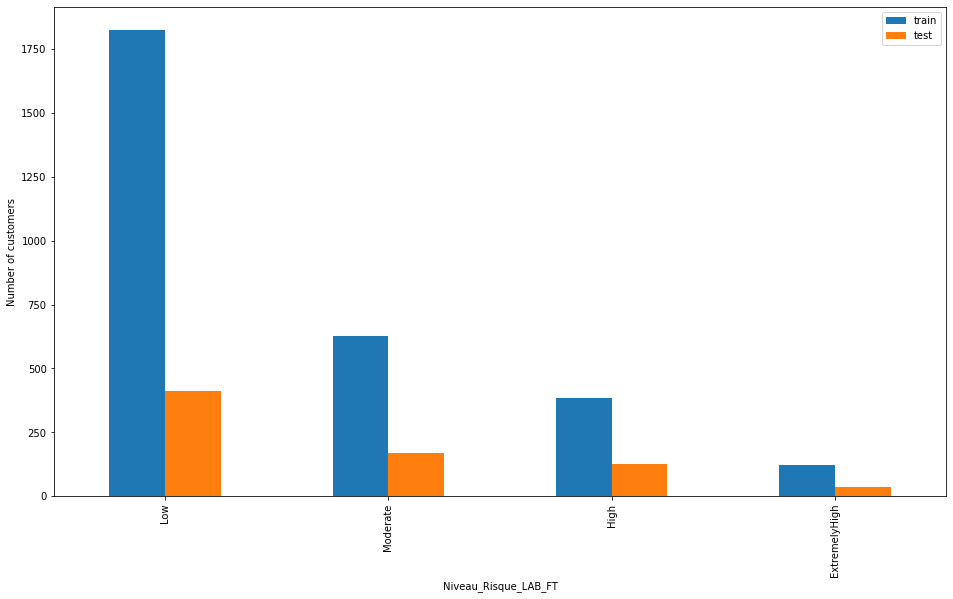

In [ ]:
VCTrain = list(Ftrain['Niveau_Risque_LAB_FT'].value_counts())
CVTest = list(Ftest['Niveau_Risque_LAB_FT'].value_counts())
# dataset is splitted 80/20 so the low categories will be given entirely to train == the length of CVTest and CVTrain not the same = error => appended 0 to CVTest
CVTest.extend([0]* (len(list(Ftrain['Niveau_Risque_LAB_FT'].value_counts())) - len(list(Ftest['Niveau_Risque_LAB_FT'].value_counts()))))

P = pd.DataFrame({ 'Niveau_Risque_LAB_FT':dfROUnique['Niveau_Risque_LAB_FT'].unique(), 'train':VCTrain, 'test':CVTest})
p = P[["Niveau_Risque_LAB_FT","train","test"]]
p.set_index(["Niveau_Risque_LAB_FT"],inplace=True)
p.plot(kind='bar',alpha=1, figsize=(16,9))
plt.ylabel('Number of customers')




---



### Train Test Split by Rib Origin AND Category-Risk : 
not possible 

the idea is to prevent that transactions from the same user will not be found in train and test 

we are going to split a data set containing unique Rib Origine == split USERS 

then, we will add to train and test data the rest of trasactions for each user 

In [ ]:
df=dfOPD.copy(deep=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47950 entries, 0 to 50635
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Référence transaction      47950 non-null  int64         
 1   DATE_TRANSACTION           47950 non-null  datetime64[ns]
 2   TYPE_TRANSACTION           47950 non-null  object        
 3   RIB origine                47950 non-null  int64         
 4   Rib bénéficiaire           47775 non-null  float64       
 5   BANQUE BéNéFICIAIRE        47950 non-null  int64         
 6   Institution intermédiaire  47950 non-null  int64         
 7   Montant                    47950 non-null  float64       
 8   Devise                     47950 non-null  int64         
 9   CA 2020                    40059 non-null  float64       
 10  Categorie                  47950 non-null  object        
 11  Tranche_Age                47387 non-null  object        
 12  Tran

In [ ]:
df['Categorie'].value_counts()

Personne morale                               35164
Personne physique                              9304
Organismes                                     1874
Autres institutions sans but lucratif           470
Autres institutions                             466
Ambassades                                      373
Associations, Partis, Syndics et Syndicats      297
Liste Campagne Electorale                         2
Name: Categorie, dtype: int64

In [ ]:
df["Categorie"].loc[df["Categorie"] == "Autres institutions"] = 'Autres institutions ou Liste Campagne Electorale ou Autres institutions sans but lucratif'
df["Categorie"].loc[df["Categorie"] == "Liste Campagne Electorale"] = 'Autres institutions ou Liste Campagne Electorale ou Autres institutions sans but lucratif'

df["Categorie"].loc[df["Categorie"] == "Autres institutions sans but lucratif"] = 'Autres institutions ou Liste Campagne Electorale ou Autres institutions sans but lucratif'




/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df['Categorie'].value_counts()

Personne morale                                                                              35164
Personne physique                                                                             9304
Organismes                                                                                    1874
Autres institutions ou Liste Campagne Electorale ou Autres institutions sans but lucratif      938
Ambassades                                                                                     373
Associations, Partis, Syndics et Syndicats                                                     297
Name: Categorie, dtype: int64

Create Column Count

In [ ]:
ROCount=df['RIB origine'].value_counts() #a
dfROCount=ROCount.to_frame().reset_index().rename(columns={'RIB origine':'Count','index':'RIB origine' }) #dfA
dfOPDC = pd.merge(dfROCount, df, on=['RIB origine']) #dfJoin
dfOPDC

df with Unique Rib Origine

In [ ]:
#List Unique RO 
ListROUnique = pd.unique(dfOPDC['RIB origine'])
# df with RO unique
dfROUnique = pd.DataFrame()
for i in ListROUnique : #L = List des RO unique 
  dfROUnique=dfROUnique.append(dfOPDC[dfOPDC['RIB origine']==i].iloc[0],ignore_index=True)

dfROUnique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3698 entries, 0 to 3697
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   RIB origine                3698 non-null   float64       
 1   Count                      3698 non-null   float64       
 2   Référence transaction      3698 non-null   float64       
 3   DATE_TRANSACTION           3698 non-null   datetime64[ns]
 4   TYPE_TRANSACTION           3698 non-null   object        
 5   Rib bénéficiaire           3674 non-null   float64       
 6   BANQUE BéNéFICIAIRE        3698 non-null   float64       
 7   Institution intermédiaire  3698 non-null   float64       
 8   Montant                    3698 non-null   float64       
 9   Devise                     3698 non-null   float64       
 10  CA 2020                    2348 non-null   float64       
 11  Categorie                  3698 non-null   object        
 12  Tranch

In [ ]:
Cat = dfROUnique['Categorie']

In [ ]:
dfROUnique['Categorie'].value_counts()

Personne morale                               2140
Personne physique                             1463
Associations, Partis, Syndics et Syndicats      37
Organismes                                      29
Ambassades                                      16
Autres institutions sans but lucratif            9
Autres institutions                              2
Liste Campagne Electorale                        2
Name: Categorie, dtype: int64

In [ ]:
dfROUnique['Cat_Risk'] = dfROUnique["Categorie"]+dfROUnique["Niveau_Risque_LAB_FT"]

In [ ]:
dfROUnique['Cat_Risk'].value_counts()

Personne moraleLow                                    1395
Personne physiqueLow                                   771
Personne moraleModerate                                575
Personne physiqueHigh                                  332
Personne physiqueModerate                              216
Personne moraleHigh                                    158
Personne physiqueExtremelyHigh                         144
Associations, Partis, Syndics et SyndicatsLow           29
OrganismesLow                                           25
Personne moraleExtremelyHigh                            12
AmbassadesLow                                            9
Associations, Partis, Syndics et SyndicatsHigh           8
AmbassadesHigh                                           5
Autres institutions sans but lucratifLow                 4
Autres institutions sans but lucratifHigh                3
OrganismesHigh                                           3
AmbassadesModerate                                      

In [ ]:
pd.concat([dfROUnique["Categorie"], dfROUnique["Niveau_Risque_LAB_FT"]], axis=1)

,Categorie,Niveau_Risque_LAB_FT
0,Personne morale,Low
1,Personne morale,Moderate
2,Organismes,Low
3,Personne morale,Moderate
4,Personne morale,Moderate
...,...,...
3693,Personne physique,Moderate
3694,Personne physique,High
3695,Personne morale,Low
3696,Personne morale,Low


In [ ]:
Ftrain, Ftest = train_test_split(dfROUnique, test_size=0.2, random_state=1,stratify=dfROUnique['Cat_Risk'] )

ValueError: ignored

In [ ]:
Ftrain['Niveau_Risque_LAB_FT'].value_counts()

Low              1823
Moderate          626
High              386
ExtremelyHigh     123
Name: Niveau_Risque_LAB_FT, dtype: int64

In [ ]:
Ftest['Niveau_Risque_LAB_FT'].value_counts()

Low              412
Moderate         168
High             125
ExtremelyHigh     35
Name: Niveau_Risque_LAB_FT, dtype: int64

In [ ]:
FFtrain=dfOPDC[dfOPDC['RIB origine'].isin(Ftrain['RIB origine'])]
FFtest=dfOPDC[dfOPDC['RIB origine'].isin(Ftest['RIB origine'])]

In [ ]:
FFtrain['Niveau_Risque_LAB_FT'].value_counts()

Low              23874
Moderate         11088
High              4225
ExtremelyHigh     1069
Name: Niveau_Risque_LAB_FT, dtype: int64

In [ ]:
train=FFtrain.copy(deep=True)
test=FFtest.copy(deep=True)



---



In [ ]:
train['RIB origine'].value_counts()

18492    1239
17111     742
21902     702
23290     695
18463     504
         ... 
14392       1
15713       1
17704       1
18105       1
24258       1
Name: RIB origine, Length: 2958, dtype: int64

In [ ]:
test['RIB origine'].value_counts()

18217    222
24574    203
15599    177
18488    138
20529    120
        ... 
23650      1
23098      1
23265      1
13934      1
19279      1
Name: RIB origine, Length: 740, dtype: int64

In [ ]:
dfJoin['Niveau_Risque_LAB_FT'].value_counts().plot.bar(rot=0, title='Niveau_Risque_LAB_FT Distribution Before Split')

### Outlier Detection



En raison de la quantité limitée de données dont nous disposons, traiter les valeurs aberrantes serait une mauvaise décision et pourrait affecter négativement la performance de notre modèle en situation réelle. Par conséquent, nous avons décidé, dans une première approche, de les laisser en place jusqu'à ce que nous obtenions plus de données.

Exploration de la méthode de traitement de ces valeurs aberrantes et test sur nos données pour visualiser son efficacité et ses résultats, mais nous ne l'avons pas réellement appliquée dans les étapes suivantes avant d'avoir plus de données.

(( ctrl m y to return then to code ))

 #### draw boxplots to visualize outliers

plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
fig = dfOPD.boxplot(column='Montant')
fig.set_title('')
fig.set_ylabel('Montant')

plt.subplot(1, 2, 2)
fig = dfOPD.boxplot(column='CA 2020')
fig.set_title('')
fig.set_ylabel('CA 2020')

#### find outliers in Montant variable
lowerboundaryMontant = dfOPD.Montant.quantile(0.10)
upperboundaryMontant = dfOPD.Montant.quantile(0.90) 
print(f'Montant outliers are values < {lowerboundaryMontant} or > {upperboundaryMontant}')

#### find outliers in Montant variable
LowerboundaryCA = dfOPD['CA 2020'].quantile(0.10) 
UpperboundaryCA = dfOPD['CA 2020'].quantile(0.90) 
print(f'CA 2020 outliers are values < {LowerboundaryCA} or > {UpperboundaryCA}')

def max_value(df, variable, top):
    return np.where(df[variable]>top, top, df[variable])

def min_value(df, variable, min):
    return np.where(df[variable]<min, min, df[variable])

dfOPD['Montant'] = max_value(dfOPD, 'Montant',upperboundaryMontant )
dfOPD['Montant'] = min_value(dfOPD, 'Montant',lowerboundaryMontant )

dfOPD['CA 2020'] = max_value(dfOPD, 'CA 2020',UpperboundaryCA ) 
dfOPD['CA 2020'] = min_value(dfOPD, 'CA 2020',LowerboundaryCA ) 

#### draw boxplots to visualize distrubition after outiliers treatement 
plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
fig = dfOPD.boxplot(column='Montant')
fig.set_title('')
fig.set_ylabel('Montant')

plt.subplot(1, 2, 2)
fig = dfOPD.boxplot(column='CA 2020')
fig.set_title('')
fig.set_ylabel('CA 2020')



---



---



###  Imputation of missing values

####1èr approche: fonction permettant de remplacer les valeurs nulles de "Column" par la valeur portant la même origine Rib : 



def RempColumnWithSameRibOrigine(dfmet): #methode 1 
    Columns=[]
    Vtraitées=[]
    #'Rib bénéficiaire',
    for column in ['CA 2020', 'Categorie', 'Tranche_Age', 'Tranche_Anciennete', 'Tranche_Salaire', 
            'Profession','Secteur_Activite', 'Politiquement_Expose', 'Niveau_Risque_LAB_FT', 'Code_Nationalite',
            'CodePostal', 'Delegation', 'Ville', 'Region']:
        #dfOPD[col] = dfOPD[col].astype('category') 
        #print('Column :', column)
        n=0
        # df CA NOT NULL ALL 
        dfCANotNullAll=dfmet.loc[dfmet[column].notnull()] 

        #List Unique RO and CA Not NUll 
        ListROUniqueCANotNull = pd.unique(dfCANotNullAll['RIB origine'])

        # df with RO unique and CA NOT NULL
        dfROUniqueCANotNull = pd.DataFrame()
        for i in ListROUniqueCANotNull : #L = List des RO unique 
            dfROUniqueCANotNull=dfROUniqueCANotNull.append(dfCANotNullAll[dfCANotNullAll['RIB origine']==i].iloc[0],ignore_index=True)
        #print('len(dfROUniqueCANotNull) ' ,len(dfROUniqueCANotNull))

        # df CA NULL ALL 
        dfCANullAll=dfmet.loc[dfmet[column].isna()] 
        #List RO unique CA Null
        ListROUniqueCANull = pd.unique(dfCANullAll['RIB origine'])

       # print('debut traitement:')
        for i in ListROUniqueCANull :
            #print(i)
            if i in ListROUniqueCANotNull :
                n+=1
        
                dffound=dfROUniqueCANotNull[column][dfROUniqueCANotNull['RIB origine']==i]
                dfremp=dffound.mean() # car ma9rach variable nrml w bima2anou wa7ed barka so mean does the job
                dfmet[column][dfmet['RIB origine']==i]=dfremp

        Columns.append(column)
        Vtraitées.append(n)
        #print('nombre de valeurs trouvées et traitées :',n)  
    
    dd = pd.DataFrame({"Columns": Columns, "valeurs trouvées et traitées": Vtraitées})
    display(dd)


  

try el visualisation a3melha fi tableau .

In [ ]:
columns = ['CA 2020', 'Categorie', 'Tranche_Age', 'Tranche_Anciennete', 'Tranche_Salaire', 'Politiquement_Expose', 'Niveau_Risque_LAB_FT', 'Code_Nationalite',
        'CodePostal', 'Delegation', 'Ville', 'Region']

results=[0,0,0,0,0,0,0,0,0,0,0,0]

dd = pd.DataFrame({"Columns": columns, "valeurs trouvées et traitées": results})

display(dd)

,Columns,valeurs trouvées et traitées
0,CA 2020,0
1,Categorie,0
2,Tranche_Age,0
3,Tranche_Anciennete,0
4,Tranche_Salaire,0
5,Politiquement_Expose,0
6,Niveau_Risque_LAB_FT,0
7,Code_Nationalite,0
8,CodePostal,0
9,Delegation,0


In [ ]:
len(columns)

12

In [ ]:
len(results)

12

In [ ]:
#RempColumnWithSameRibOrigine(train)
#RempColumnWithSameRibOrigine(test)

####2ème approche: traiter chaque variable avec des fonctions spécifiques


##### functions:

In [ ]:
#function remplacer les valeurs nulles de C1 par le valeur le plus frequent des transactions appartients au meme intersection entre C2 et C3 :
def most_frequent(List) :
    return max(set(List), key = List.count)

def RempC1WithPlusFreqInterectionC2AndC3(dfOPD,C1,C2,C3) :
    ListUniqueRO = pd.unique(dfOPD['RIB origine'])
    dfUniqueRO = pd.DataFrame()
    for i in ListUniqueRO : #L = List des RO unique 
        dfUniqueRO=dfUniqueRO.append(dfOPD[dfOPD['RIB origine']==i].iloc[0],ignore_index=True)
    #print("len df uniqueRO",len(dfUniqueRO))

    ListC2 = dfOPD[C2].unique()
    ListC3 = dfOPD[C3].unique()

    def dfCroisementFunction(df,x,y): #df = data set // x = Type SA // y = Type Categorie 
        return df[(df[C2]==x) & (df[C3]==y)] # need na5dhou el nombre de transaction MOUCH el Rob Origine 

    for i in ListC2 :
        for j in ListC3 :
            #print("i",i)
           # print("j",j)
            # df Croisement ALL ( will be unsed to replace null variables )
            dfCroisementAll=dfCroisementFunction(dfOPD,i,j)
            #print("Totalite ALL ",len(dfCroisementAll))

            # df Croisement NULL ALL ( will be unsed to replace null variables )
            dfCroisementNullAll=dfCroisementAll.loc[dfCroisementAll[C1].isna()] 
            #print("Null ALL ",len(dfCroisementNullAll))

            # df Croisement des RO Unique 
            dfCroisementUnique=dfCroisementFunction(dfUniqueRO,i,j)
            #print("totalite unique",len(dfCroisementUnique))

            # dfCroissement avec RO unique NULL 
            dfCroisementNull = dfCroisementUnique.loc[dfCroisementUnique[C1].isna()]  
            #print("Null unique ",len(dfCroisementNull))

            # dfCroissement avec RO unique NOT NULL 
            dfCroisementNotNull = dfCroisementUnique.loc[dfCroisementUnique[C1].notnull()]  
            #print("Not Null unique ",len(dfCroisementNotNull))

            #pourcentage
            if(len(dfCroisementUnique)==0) :
                Pourcentage = 0
            else : 
                Pourcentage=(len(dfCroisementNull)/len(dfCroisementUnique))*100  #lazem ne9esmou 3al TOTAL        
            #print("Pourcentage ",Pourcentage)

            if (Pourcentage<50)&(Pourcentage>0) :
                
                #df croiseement avc RO Unique and TS not Null 
                b=dfCroisementNotNull[C1].to_list() 
                
                if (len(b)!=0): 
                    #dfOPD[C1][dfOPD['RIB origine']==RO]= most_frequent(b)
                    
                    dfOPD[C1][(dfOPD[C2]==i) & (dfOPD[C3]==j)& (dfOPD[C1].isna())]=  most_frequent(b) 
                    #print('most_frequent b : ',most_frequent(b))
                    
                #calcul el mean 
                #mean=dfCroisementNotNull[C1].mean()
                #print("Mean ",mean)

                #bech nbadel mel dfmet win el fama croisement and CA = Null 
                #print("finale ",dfmet[(dfmet['Secteur_Activite']==i) & (dfmet['Categorie']==j)& (dfmet['CA 2020'].isna())].loc[:,'CA 2020'])
                #dfmet[(dfmet['Secteur_Activite']==i) & (dfmet['Categorie']==j)& (dfmet['CA 2020'].isna())].loc[:,'CA 2020']= mean

                #dfOPD[C1][(dfOPD[C2]==i) & (dfOPD[C3]==j)& (dfOPD[C1].isna())]= mean

                #BOUCLE 



                #print("after ",dfmet[(dfmet['Secteur_Activite']==i) & (dfmet['Categorie']==j)])


In [ ]:
#Fonction permettant de remplacer les valeurs nulles de C1 par la valeur la plus frequente des valeurs des transactions ayant la même valeur de la colonne C2: 
def RempC1WithFreqC1WithSameC2(dfOPD,C1,C2):
    
    #List Unique RO 
    ListROUnique = pd.unique(dfOPD['RIB origine'])
    # df with RO unique
    dfROUnique = pd.DataFrame()
    for i in ListROUnique : #L = List des RO unique 
        dfROUnique=dfROUnique.append(dfOPD[dfOPD['RIB origine']==i].iloc[0],ignore_index=True)
    #print('len(dfROUnique) ' ,len(dfROUnique))
    
    dfCPNotNull = dfOPD.loc[dfOPD[C1].notnull()] 
    
    n=0
    dfCNull= dfROUnique[dfROUnique[C1].isna()]
    #print('dfCNull :', dfCNull.info())
    #List Rib origine des fdCNNull :
    LRO= dfCNull['RIB origine']
    #print('len(LRO)',len(LRO))
    for RO in LRO :
        NR=dfROUnique[C2][dfROUnique['RIB origine']==RO]
        #print('NR :',NR)
        #m=median(dfOPD['Code_Nationalite'][dfOPD['Niveau_Risque_LAB_FT']==NR])
        #print(m)
        #b=dfOPD['Code_Nationalite'][dfOPD['Niveau_Risque_LAB_FT']==NR].to_list()
        b=dfCPNotNull[C1][dfCPNotNull[C2].isin(NR)].to_list()  
       # print('CodePostal in b :' ,dfOPD['CodePostal'][dfOPD['Code_Nationalite'].isin(NR)]  )
        #print('len b : ',len(b))
        #print('b',b)
        #print(most_frequent(b))
        #print(most_frequent(dfOPD['Code_Nationalite'][dfOPD['Niveau_Risque_LAB_FT']==NR].to_list()))

        if (len(b)!=0):
            Freq=  most_frequent(b)
            dfOPD[C1][dfOPD['RIB origine']==RO]= Freq
            #print('most_frequent b : ',most_frequent(b))
            n+=1
            
        #print("nmbr d'execution :", n)


In [ ]:
#Remplacer les valeur nulles par la valeur la plus frequente de toutes les transactions :
def RempC1ParPlusFreq(dfOPD,C1): #C1 = SA  V = valeur 
    
    #List Unique RO 
    ListROUnique = pd.unique(dfOPD['RIB origine'])
    # df with RO unique
    dfROUnique = pd.DataFrame()
    for i in ListROUnique : #L = List des RO unique 
        dfROUnique=dfROUnique.append(dfOPD[dfOPD['RIB origine']==i].iloc[0],ignore_index=True)
    #print('len(dfROUnique) ' ,len(dfROUnique))
          
    n=0
    dfCNull= dfROUnique[dfROUnique[C1].isna()] 

    #print('dfCNull :', dfCNull.info())
    #List Rib origine des fdCNNull :
    LRO= dfCNull['RIB origine']
    #print('len(LRO)',len(LRO))
    
    # la valeur la plus frequente :
    
    dfCPNotNull = dfOPD.loc[dfOPD[C1].notnull()]
    b=dfCPNotNull[C1].to_list()  
    Freq=  most_frequent(b) 
    #print('Freq',Freq)
    for RO in LRO :
        dfOPD[C1][dfOPD['RIB origine']==RO]=Freq
        n+=1
    print(n)


In [ ]:
#Fonction permettant de remplacer les valeurs nulles de C1 par la valeur la plus fréquente des transactions ayant la meme valeur de colonne C2 :

def most_frequent(List) :
    return max(set(List), key = List.count)

def RempC1WithMostFreqInC1WithSameC2(dfOPD,C1,C2):
    
    #List Unique RO 
    ListROUnique = pd.unique(dfOPD['RIB origine'])
    # df with RO unique
    dfROUnique = pd.DataFrame()
    for i in ListROUnique : #L = List des RO unique 
        dfROUnique=dfROUnique.append(dfOPD[dfOPD['RIB origine']==i].iloc[0],ignore_index=True)
    #print('len(dfROUnique) ' ,len(dfROUnique))
    
    dfCPNotNull = dfOPD.loc[dfOPD[C1].notnull()] 
    
    n=0
    dfCNull= dfROUnique[dfROUnique[C1].isna()]
    #print('dfCNull :', dfCNull.info())
    #List Rib origine des fdCNNull :
    LRO= dfCNull['RIB origine']
    #print('len(LRO)',len(LRO))
    for RO in LRO :
        NR=dfROUnique[C2][dfROUnique['RIB origine']==RO]
        #print('NR :',NR)
        #m=median(dfOPD['Code_Nationalite'][dfOPD['Niveau_Risque_LAB_FT']==NR])
        #print(m)
        #b=dfOPD['Code_Nationalite'][dfOPD['Niveau_Risque_LAB_FT']==NR].to_list()
        b=dfCPNotNull[C1][dfCPNotNull[C2].isin(NR)].to_list() # lazem nejbed men list afihech el null 
       # print('CodePostal in b :' ,dfOPD['CodePostal'][dfOPD['Code_Nationalite'].isin(NR)]  )
        #print('len b : ',len(b))
        #print('b',b)
        #print(most_frequent(b))
        #print(most_frequent(dfOPD['Code_Nationalite'][dfOPD['Niveau_Risque_LAB_FT']==NR].to_list()))
        
        if (len(b)!=0): 
            dfOPD[C1][dfOPD['RIB origine']==RO]= most_frequent(b)
            #print('most_frequent b : ',most_frequent(b))

        n+=1
    #print(n)


##### « Politiquement_Expose »: 


In [ ]:
for t in [train,test]:
    t["Politiquement_Expose"].fillna(0, inplace = True) 


##### « Rib bénéficiaire » : 
remplacer les valeurs null par des valeurs aleatoires non existante

In [ ]:
import random
from random import randint

def RempRandom(dfOPD):
    #liste reference transaction : 
    ListRT = dfOPD['Référence transaction'][dfOPD['Rib bénéficiaire'].isna()]

    n=0
    while(ListRT.any()):
        for i in ListRT :
            #print('i',i)
            dfRBNotNull = dfOPD.loc[dfOPD['Rib bénéficiaire'].notnull()]  

            ListRibBeneficiaire = pd.unique(dfRBNotNull['Rib bénéficiaire'])
            #print('len(ListRibBeneficiaire)',len(ListRibBeneficiaire))

            r=randint(10000, 100000)
            if(not (r in ListRibBeneficiaire) ):
                #dfOPD["Rib bénéficiaire"].fillna(a, inplace = True) 
                #affectation dis variable l RB 
                #print('r',r)
                dfOPD['Rib bénéficiaire'][dfOPD['Référence transaction']== i]=r
                n+=1

        ListRT = dfOPD['Référence transaction'][dfOPD['Rib bénéficiaire'].isna()]

    print('nombre de valeurs trouvées et traitées :',n)   


for t in [train,test]:
    RempRandom(t)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


nombre de valeurs trouvées et traitées : 154
nombre de valeurs trouvées et traitées : 21




---



---



##### « Code_Nationalite », « Tranche_Anciennete » et « Categorie » :

no null values due to removing the null RIsk 

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40256 entries, 0 to 47949
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   RIB origine                40256 non-null  int64         
 1   Count                      40256 non-null  int64         
 2   Référence transaction      40256 non-null  int64         
 3   DATE_TRANSACTION           40256 non-null  datetime64[ns]
 4   TYPE_TRANSACTION           40256 non-null  object        
 5   Rib bénéficiaire           40256 non-null  float64       
 6   BANQUE BéNéFICIAIRE        40256 non-null  int64         
 7   Institution intermédiaire  40256 non-null  int64         
 8   Montant                    40256 non-null  float64       
 9   Devise                     40256 non-null  int64         
 10  CA 2020                    34082 non-null  float64       
 11  Categorie                  40256 non-null  object        
 12  Tran

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7694 entries, 7960 to 47947
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   RIB origine                7694 non-null   int64         
 1   Count                      7694 non-null   int64         
 2   Référence transaction      7694 non-null   int64         
 3   DATE_TRANSACTION           7694 non-null   datetime64[ns]
 4   TYPE_TRANSACTION           7694 non-null   object        
 5   Rib bénéficiaire           7694 non-null   float64       
 6   BANQUE BéNéFICIAIRE        7694 non-null   int64         
 7   Institution intermédiaire  7694 non-null   int64         
 8   Montant                    7694 non-null   float64       
 9   Devise                     7694 non-null   int64         
 10  CA 2020                    5977 non-null   float64       
 11  Categorie                  7694 non-null   object        
 12  Tr



---



##### « Secteur_Activite » : 
Remplacer les valeur nulles par La valeur "ACTIVITES DE SERVICES MANQUANTE" 

In [ ]:
def RempC1ParV(dfOPD,C1,V): #C1 = SA  V = valeur 
    
    #List Unique RO 
    ListROUnique = pd.unique(dfOPD['RIB origine'])
    # df with RO unique
    dfROUnique = pd.DataFrame()
    for i in ListROUnique : #L = List des RO unique 
        dfROUnique=dfROUnique.append(dfOPD[dfOPD['RIB origine']==i].iloc[0],ignore_index=True)
    #print('len(dfROUnique) ' ,len(dfROUnique))
          
    n=0
    dfCNull= dfROUnique[dfROUnique[C1].isna()] 

    #print('dfCNull :', dfCNull.info())
    #List Rib origine des fdCNNull :
    LRO= dfCNull['RIB origine']
    #print('len(LRO)',len(LRO))
    for RO in LRO :
        
        dfOPD[C1][dfOPD['RIB origine']==RO]=V

        n+=1
    #print(n)

for t in [train,test]:
    RempC1ParV(t,"Secteur_Activite","ACTIVITES DE SERVICES MANQUANTE")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##### « CA 2020 » : 
Remplacer les valeurs nulles par la valeur moyenne des transactions apparentes à la même intersection entre "Secteur_Activite" et "Categorie"\
ou seulement "Secteur_Activite"

In [ ]:
#Fonction permettant de remplacer les valeurs nulles de C1 par la valeur moyenne des transactions apparentes à la même intersection entre C2 et C3: 
def RempC1WithMoyInterectionC2AndC3(dfOPD,C1,C2,C3) :
    ListUniqueRO = pd.unique(dfOPD['RIB origine'])
    dfUniqueRO = pd.DataFrame()
    for i in ListUniqueRO : #L = List des RO unique 
        dfUniqueRO=dfUniqueRO.append(dfOPD[dfOPD['RIB origine']==i].iloc[0],ignore_index=True)
   # print(len(dfUniqueRO))

    ListSA = dfOPD[C2].unique()
    ListCategory = dfOPD[C3].unique()

    def dfCroisementFunction(df,x,y): #df = data set // x = Type SA // y = Type Categorie 
        return df[(df[C2]==x) & (df[C3]==y)] # need na5dhou el nombre de transaction MOUCH el Rob Origine 

    for i in ListSA :
        for j in ListCategory :
            #print(i)
            #print(j)
            # df Croisement ALL ( will be unsed to replace null variables )
            dfCroisementAll=dfCroisementFunction(dfOPD,i,j)
            #print("Totalite ALL ",len(dfCroisementAll))

            # df Croisement NULL ALL ( will be unsed to replace null variables )
            dfCroisementNullAll=dfCroisementAll.loc[dfCroisementAll[C1].isna()] 
            #print("Null ALL ",len(dfCroisementNullAll))

            # df Croisement des RO Unique 
            dfCroisementUnique=dfCroisementFunction(dfUniqueRO,i,j)
            #print("totalite unique",len(dfCroisementUnique))

            # dfCroissement avec RO unique NULL 
            dfCroisementNull = dfCroisementUnique.loc[dfCroisementUnique[C1].isna()]  
            #print("Null unique ",len(dfCroisementNull))

            # dfCroissement avec RO unique NOT NULL 
            dfCroisementNotNull = dfCroisementUnique.loc[dfCroisementUnique[C1].notnull()]  
            #print("Not Null unique ",len(dfCroisementNotNull))

            #pourcentage
            if(len(dfCroisementUnique)==0) :
                Pourcentage = 0
            else : 
                Pourcentage=(len(dfCroisementNull)/len(dfCroisementUnique))*100  #lazem ne9esmou 3al TOTAL        
            #print("Pourcentage ",Pourcentage)

            if (Pourcentage<50)&(Pourcentage>0) :
                #calcul el mean 
                mean=dfCroisementNotNull[C1].mean()
                #print("Mean ",mean)

                #bech nbadel mel dfmet win el fama croisement and CA = Null 
                #print("finale ",dfmet[(dfmet['Secteur_Activite']==i) & (dfmet['Categorie']==j)& (dfmet['CA 2020'].isna())].loc[:,'CA 2020'])
                #dfmet[(dfmet['Secteur_Activite']==i) & (dfmet['Categorie']==j)& (dfmet['CA 2020'].isna())].loc[:,'CA 2020']= mean

                dfOPD[C1][(dfOPD[C2]==i) & (dfOPD[C3]==j)& (dfOPD[C1].isna())]= mean

                #BOUCLE 



                #print("after ",dfmet[(dfmet['Secteur_Activite']==i) & (dfmet['Categorie']==j)])

for t in [train,test]:
    RempC1WithMoyInterectionC2AndC3(t,'CA 2020','Secteur_Activite','Categorie')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#Fonction permettant de remplacer les valeurs nulles de C1 par la moyenne des valeurs des transactions ayant la même valeur de la colonne C2:
def most_frequent(List) :
    return max(set(List), key = List.count)

def RempC1WithMoyC1WithSameC2(dfOPD,C1,C2):
    
    #List Unique RO 
    ListROUnique = pd.unique(dfOPD['RIB origine'])
    # df with RO unique
    dfROUnique = pd.DataFrame()
    for i in ListROUnique : #L = List des RO unique 
        dfROUnique=dfROUnique.append(dfOPD[dfOPD['RIB origine']==i].iloc[0],ignore_index=True)
    #print('len(dfROUnique) ' ,len(dfROUnique))
    
    dfCPNotNull = dfOPD.loc[dfOPD[C1].notnull()] 
    
    n=0
    dfCNull= dfROUnique[dfROUnique[C1].isna()]
    #print('dfCNull :', dfCNull.info())
    #List Rib origine des fdCNNull :
    LRO= dfCNull['RIB origine']
    #print('len(LRO)',len(LRO))
    for RO in LRO :
        NR=dfROUnique[C2][dfROUnique['RIB origine']==RO]
        #print('NR :',NR)
        #m=median(dfOPD['Code_Nationalite'][dfOPD['Niveau_Risque_LAB_FT']==NR])
        #print(m)
        #b=dfOPD['Code_Nationalite'][dfOPD['Niveau_Risque_LAB_FT']==NR].to_list()
        b=dfCPNotNull[C1][dfCPNotNull[C2].isin(NR)] 
       # print('CodePostal in b :' ,dfOPD['CodePostal'][dfOPD['Code_Nationalite'].isin(NR)]  )
        #print('len b : ',len(b))
        #print('b',b)
        #print(most_frequent(b))
        #print(most_frequent(dfOPD['Code_Nationalite'][dfOPD['Niveau_Risque_LAB_FT']==NR].to_list()))

        if (len(b)!=0):
            mean=b.mean()
            dfOPD[C1][dfOPD['RIB origine']==RO]= mean
            #print('most_frequent b : ',most_frequent(b))
            n+=1
            
    print(n)

#Remplacer les valeurs nulles de CA par la moyenne des valeurs ayant la meme SA ou la meme CA:
for t in [train,test]:
    RempC1WithMoyC1WithSameC2(t,'CA 2020','Secteur_Activite')
    
#for t in [train,test]:
   # RempC1WithMoyC1WithSameC2(t,'CA 2020','Categorie')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


727
184


##### « Tranche_Age » 

In [ ]:
#Fonction permettant de remplacer les valeurs nulles de C1 par la valeur moyenne des transactions apparentes à la même intersection entre C2 et C3 et C4:

def most_frequent(List) :
    return max(set(List), key = List.count)

def RempC1WithPlusFreqInterectionC2AndC3AndC4(dfOPD,C1,C2,C3,C4) :
    ListUniqueRO = pd.unique(dfOPD['RIB origine'])
    dfUniqueRO = pd.DataFrame()
    for i in ListUniqueRO : #L = List des RO unique 
        dfUniqueRO=dfUniqueRO.append(dfOPD[dfOPD['RIB origine']==i].iloc[0],ignore_index=True)
    #print("len df uniqueRO",len(dfUniqueRO))

    ListC2 = dfOPD[C2].unique()
    ListC3 = dfOPD[C3].unique()
    ListC4 = dfOPD[C4].unique()

    def dfCroisementFunction(df,x,y,z): #df = data set // x = Type SA // y = Type Categorie 
        return df[(df[C2]==x) & (df[C3]==y) & (df[C4]==z)] # need na5dhou el nombre de transaction MOUCH el Rob Origine 

    for z in ListC4 :
        for i in ListC2 :
            for j in ListC3 :
                #print("z",z)
                #print("i",i)
                #print("j",j)
                # df Croisement ALL ( will be unsed to replace null variables )
                dfCroisementAll=dfCroisementFunction(dfOPD,i,j,z)
                #print("Totalite ALL ",len(dfCroisementAll))

                # df Croisement NULL ALL ( will be unsed to replace null variables )
                dfCroisementNullAll=dfCroisementAll.loc[dfCroisementAll[C1].isna()] 
                #print("Null ALL ",len(dfCroisementNullAll))

                # df Croisement des RO Unique 
                dfCroisementUnique=dfCroisementFunction(dfUniqueRO,i,j,z)
                #print("totalite unique",len(dfCroisementUnique))

                # dfCroissement avec RO unique NULL 
                dfCroisementNull = dfCroisementUnique.loc[dfCroisementUnique[C1].isna()]  
                #print("Null unique ",len(dfCroisementNull))

                # dfCroissement avec RO unique NOT NULL 
                dfCroisementNotNull = dfCroisementUnique.loc[dfCroisementUnique[C1].notnull()]  
                #print("Not Null unique ",len(dfCroisementNotNull))

                #pourcentage
                if(len(dfCroisementUnique)==0) :
                    Pourcentage = 0
                else : 
                    Pourcentage=(len(dfCroisementNull)/len(dfCroisementUnique))*100  #lazem ne9esmou 3al TOTAL        
                #print("Pourcentage ",Pourcentage)

                if (Pourcentage<50)&(Pourcentage>0) :

                    #df croiseement avc RO Unique and TS not Null 
                    b=dfCroisementNotNull[C1].to_list() 

                    if (len(b)!=0): 
                        #dfOPD[C1][dfOPD['RIB origine']==RO]= most_frequent(b)

                        dfOPD[C1][(dfOPD[C2]==i) & (dfOPD[C3]==j) & (dfOPD[C4]==z) & (dfOPD[C1].isna())]=  most_frequent(b) 
                        #print('most_frequent b : ',most_frequent(b))

                    #calcul el mean 
                    #mean=dfCroisementNotNull[C1].mean()
                    #print("Mean ",mean)

                    #bech nbadel mel dfmet win el fama croisement and CA = Null 
                    #print("finale ",dfmet[(dfmet['Secteur_Activite']==i) & (dfmet['Categorie']==j)& (dfmet['CA 2020'].isna())].loc[:,'CA 2020'])
                    #dfmet[(dfmet['Secteur_Activite']==i) & (dfmet['Categorie']==j)& (dfmet['CA 2020'].isna())].loc[:,'CA 2020']= mean

                    #dfOPD[C1][(dfOPD[C2]==i) & (dfOPD[C3]==j)& (dfOPD[C1].isna())]= mean

                    #BOUCLE 



                    #print("after ",dfmet[(dfmet['Secteur_Activite']==i) & (dfmet['Categorie']==j)])

for t in [train,test]:
    RempC1WithPlusFreqInterectionC2AndC3AndC4(t,'Tranche_Age','Categorie','Tranche_Anciennete','Code_Nationalite')
    RempC1WithPlusFreqInterectionC2AndC3(t,'Tranche_Age','Categorie','Tranche_Anciennete')
    RempC1WithPlusFreqInterectionC2AndC3(t,'Tranche_Age','Categorie','Code_Nationalite')
    #RempC1WithPlusFreqInterectionC2AndC3(t,'Tranche_Age','Tranche_Anciennete','Code_Nationalite')
    #RempC1WithFreqC1WithSameC2(t,'Tranche_Age','Tranche_Anciennete')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




---



---



##### Ville

Ville ne depend pas de Code Nat et Region\
ville depend de Delegation et  Code Postal mais quand ville == null, Delegation == null \
so fist w're gonna work with CN and CP and then CN alone


In [ ]:
train1=train.copy(deep=True)
test1=test.copy(deep=True)

In [ ]:
for t in [train,test]:
    RempC1WithMoyInterectionC2AndC3(t,'Ville','Code_Nationalite','CodePostal')
    RempC1WithMostFreqInC1WithSameC2(t,'Ville','CodePostal')
    RempC1WithMostFreqInC1WithSameC2(t,'Ville','Code_Nationalite')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




---



---



In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40256 entries, 0 to 47949
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   RIB origine                40256 non-null  int64         
 1   Count                      40256 non-null  int64         
 2   Référence transaction      40256 non-null  int64         
 3   DATE_TRANSACTION           40256 non-null  datetime64[ns]
 4   TYPE_TRANSACTION           40256 non-null  object        
 5   Rib bénéficiaire           40256 non-null  float64       
 6   BANQUE BéNéFICIAIRE        40256 non-null  int64         
 7   Institution intermédiaire  40256 non-null  int64         
 8   Montant                    40256 non-null  float64       
 9   Devise                     40256 non-null  int64         
 10  CA 2020                    40253 non-null  float64       
 11  Categorie                  40256 non-null  object        
 12  Tran

In [ ]:
test.info

<bound method DataFrame.info of        RIB origine  Count  Référence transaction DATE_TRANSACTION  \
7960         18217    222                   1025       2019-12-18   
7961         18217    222                   1117       2019-01-23   
7962         18217    222                  68718       2020-01-21   
7963         18217    222                  70908       2019-12-18   
7964         18217    222                  76253       2019-12-27   
...            ...    ...                    ...              ...   
47933        22116      1                 105260       2020-11-20   
47935        21552      1                 104108       2021-01-27   
47938        15423      1                 106257       2020-06-04   
47945        17755      1                 103535       2019-10-04   
47947        19279      1                 102534       2019-12-23   

      TYPE_TRANSACTION  Rib bénéficiaire  BANQUE BéNéFICIAIRE  \
7960               OPF           25432.0                   93   
7961     

### Removing rows with null values 

In [ ]:
for t in [train,test]:
  t.drop(["CodePostal","Delegation","Region"], axis = 1, inplace = True)

In [ ]:
for t in [train,test]:
  t.dropna(inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39859 entries, 0 to 47949
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   RIB origine                39859 non-null  int64         
 1   Count                      39859 non-null  int64         
 2   Référence transaction      39859 non-null  int64         
 3   DATE_TRANSACTION           39859 non-null  datetime64[ns]
 4   TYPE_TRANSACTION           39859 non-null  object        
 5   Rib bénéficiaire           39859 non-null  float64       
 6   BANQUE BéNéFICIAIRE        39859 non-null  int64         
 7   Institution intermédiaire  39859 non-null  int64         
 8   Montant                    39859 non-null  float64       
 9   Devise                     39859 non-null  int64         
 10  CA 2020                    39859 non-null  float64       
 11  Categorie                  39859 non-null  object        
 12  Tran

In [ ]:
train['RIB origine'].value_counts()

18492    1239
17111     742
21902     702
23290     695
18463     504
         ... 
15713       1
17704       1
18105       1
14933       1
24258       1
Name: RIB origine, Length: 2937, dtype: int64

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7670 entries, 7960 to 47947
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   RIB origine                7670 non-null   int64         
 1   Count                      7670 non-null   int64         
 2   Référence transaction      7670 non-null   int64         
 3   DATE_TRANSACTION           7670 non-null   datetime64[ns]
 4   TYPE_TRANSACTION           7670 non-null   object        
 5   Rib bénéficiaire           7670 non-null   float64       
 6   BANQUE BéNéFICIAIRE        7670 non-null   int64         
 7   Institution intermédiaire  7670 non-null   int64         
 8   Montant                    7670 non-null   float64       
 9   Devise                     7670 non-null   int64         
 10  CA 2020                    7670 non-null   float64       
 11  Categorie                  7670 non-null   object        
 12  Tr

In [ ]:
test['RIB origine'].value_counts()

18217    222
24574    203
15599    177
18488    138
20529    120
        ... 
23650      1
23098      1
23265      1
13934      1
19279      1
Name: RIB origine, Length: 735, dtype: int64

### Output Train and Test data 

In [ ]:
from google.colab import files
train.to_csv('TrainSetV03.csv') 
files.download('TrainSetV03.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test.to_csv('TestSetV03.csv') 
files.download('TestSetV03.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---



---



## Part 2

### Importing Train and Test Sets

In [ ]:
uploaded = files.upload() #TrainSetV03 and TestSetV03

Saving TestSetV03.csv to TestSetV03.csv
Saving TrainSetV03.csv to TrainSetV03.csv


In [ ]:
dataTrain = pd.read_csv(io.BytesIO(uploaded['TrainSetV03.csv']))
dataTest = pd.read_csv(io.BytesIO(uploaded['TestSetV03.csv']))

dataTrain.drop(["Unnamed: 0"], axis = 1, inplace = True)
dataTest.drop(["Unnamed: 0"], axis = 1, inplace = True)
for t in [dataTrain,dataTest]:
    for col in ['TYPE_TRANSACTION', 'Devise', 'Categorie', 'Tranche_Age', 'Tranche_Anciennete','Secteur_Activite', 'Politiquement_Expose', 'Niveau_Risque_LAB_FT', 'Code_Nationalite']:
        t[col] = t[col].astype('category')


In [ ]:
dataTrain['Niveau_Risque_LAB_FT'].value_counts()

Low              23501
Moderate         10572
High              4254
ExtremelyHigh     1348
Name: Niveau_Risque_LAB_FT, dtype: int64

In [ ]:
dataTest['Niveau_Risque_LAB_FT'].value_counts()

Low              4427
Moderate         2196
High              999
ExtremelyHigh     259
Name: Niveau_Risque_LAB_FT, dtype: int64



---



---



### Resetting Train and Test Sets



---



---



In [ ]:
#
tr=train.copy(deep=True)
te=test.copy(deep=True)



---



---



---



---



---



In [ ]:
#
train=tr.copy(deep=True)
test=te.copy(deep=True)

### Création des nouveaux caractéristiques

#### CA_Band

train['CA 2020'].value_counts()

max = 14 
train_test = pd.concat([train, test], axis=0)

train_test['CA_Band'] = pd.qcut(train_test['CA 2020'], 14)
train_test[['CA_Band', 'Niveau_Risque_LAB_FT']].groupby(['CA_Band'], as_index=False).mean().sort_values(by='CA_Band', ascending=True)


DfCa_Band = train_test[['Référence transaction','CA_Band']]
DfCa_Band

train= pd.merge(train, DfCa_Band, how="left", on='Référence transaction')
test= pd.merge(test, DfCa_Band, how="left", on='Référence transaction')

for  t in [train,test]:  
  t=t.drop(['CA 2020'], axis = 1, inplace = True)

train['CA_Band'].value_counts()



---



---



#### Secteur_Activite column ( DONE )



In [ ]:
train['Secteur_Activite'][~train['Niveau_Risque_LAB_FT'].isin(['High','ExtremelyHigh'])].value_counts()

INDUSTRIE MANUFACTURIERE                                                                                                          12282
COMMERCE; REPARATION D'AUTOMOBILES ET DE MOTOCYCLES                                                                                6425
ACTIVITES DE SERVICES MANQUANTE                                                                                                    5176
TRANSPORTS ET ENTREPOSAGE                                                                                                          2236
ACTIVITES FINANCIERES ET D'ASSURANCE                                                                                               1630
PRODUCTION ET DISTRIBUTION D'ELECTRICITE, DE GAZ, DE VAPEUR ET D'AIR CONDITIONNE                                                   1608
ACTIVITES DE SERVICES ADMINISTRATIFS ET DE SOUTIEN                                                                                  997
INDUSTRIES EXTRACTIVES                          



---



---



In [ ]:
train['Secteur_Activite'].value_counts()

INDUSTRIE MANUFACTURIERE                                                                                                          13262
ACTIVITES DE SERVICES MANQUANTE                                                                                                    8235
COMMERCE; REPARATION D'AUTOMOBILES ET DE MOTOCYCLES                                                                                6670
TRANSPORTS ET ENTREPOSAGE                                                                                                          2305
ACTIVITES FINANCIERES ET D'ASSURANCE                                                                                               1634
PRODUCTION ET DISTRIBUTION D'ELECTRICITE, DE GAZ, DE VAPEUR ET D'AIR CONDITIONNE                                                   1608
INDUSTRIES EXTRACTIVES                                                                                                             1052
ACTIVITES DE SERVICES ADMINISTRATIFS ET DE SOUTI

In [ ]:
for t in [train,test]:  
  t["Secteur_Activite"].loc[~t["Secteur_Activite"].isin(['INDUSTRIE MANUFACTURIERE','ACTIVITES DE SERVICES MANQUANTE','COMMERCE; REPARATION D\'AUTOMOBILES ET DE MOTOCYCLES'])] = "AUTRES ACTIVITES DE SERVICES "

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Tranche_Age column ( DONE ) 

In [ ]:
train['Tranche_Age'].value_counts()

Tranche sup 25     13310
Tranche 8 - 15      7731
Tranche 16 - 25     7419
Tranche sup 60      5168
Tranche 4 - 7       2871
Tranche 51 - 60     1370
Tranche 2 - 3       1118
Tranche 36 - 50      570
Tranche 26 - 35      163
Tranche max 1        129
Tranche 0 - 25        10
Name: Tranche_Age, dtype: int64

In [ ]:
test['Tranche_Age'].value_counts()

Tranche sup 25     1874
Tranche 8 - 15     1527
Tranche sup 60     1496
Tranche 16 - 25    1371
Tranche 4 - 7       580
Tranche 2 - 3       276
Tranche 51 - 60     271
Tranche 36 - 50     182
Tranche max 1        58
Tranche 26 - 35      31
Tranche 0 - 25        4
Name: Tranche_Age, dtype: int64

In [ ]:
# train is already m9asem so just minimize el ta9sim V03 ( accuracy = 48-43-43-42 )
for t in [train,test]:

  t["Tranche_Age"].loc[t["Tranche_Age"] == "Tranche sup 60"] = "Tranche sup 50"
  t["Tranche_Age"].loc[t["Tranche_Age"] == "Tranche 51 - 60"] = "Tranche sup 50"

  t["Tranche_Age"].loc[t["Tranche_Age"] == "Tranche 36 - 50"] = "Tranche 25 - 50"
  t["Tranche_Age"].loc[t["Tranche_Age"] == "Tranche 26 - 35"] = "Tranche 25 - 50"

  t["Tranche_Age"].loc[t["Tranche_Age"] == "Tranche sup 25"] = "Tranche sup 25"

  t["Tranche_Age"].loc[t["Tranche_Age"] == "Tranche 16 - 25"] = "Tranche 8 - 25"
  t["Tranche_Age"].loc[t["Tranche_Age"] == "Tranche 8 - 15"] = "Tranche 8 - 25"

  t["Tranche_Age"].loc[t["Tranche_Age"] == "Tranche 0 - 25"] = "Tranche 0 - 25"

  t["Tranche_Age"].loc[t["Tranche_Age"] == "Tranche 4 - 7"] = "Tranche 4 - 7"
  
  t["Tranche_Age"].loc[t["Tranche_Age"] == "Tranche 2 - 3"] = "Tranche 2 - 3"

  t["Tranche_Age"].loc[t["Tranche_Age"] == "Tranche max 1"] = "Tranche max 1"

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Categorie Column ( DONE )

In [ ]:
train['Categorie'].value_counts()

Personne morale                               29997
Personne physique                              7281
Organismes                                     1592
Autres institutions                             466
Associations, Partis, Syndics et Syndicats      277
Autres institutions sans but lucratif           242
Ambassades                                        2
Liste Campagne Electorale                         2
Name: Categorie, dtype: int64

In [ ]:
test['Categorie'].value_counts()

Personne morale                               5156
Personne physique                             1984
Organismes                                     282
Autres institutions sans but lucratif          228
Associations, Partis, Syndics et Syndicats      20
Name: Categorie, dtype: int64

In [ ]:
#V01:
train["Categorie"].loc[train["Categorie"] != "Personne physique"] = 'Personne morale'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
test["Categorie"].loc[test["Categorie"] != "Personne physique"] = 'Personne morale'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### * MontantDev, Year, Quarter

In [ ]:
for t in [train,test]:
  t['MontantDev'] = t.apply(lambda row: row.Montant * row.Devise, axis=1)

  t['day'] = pd.DatetimeIndex(t['DATE_TRANSACTION']).day 
  t['week'] = pd.DatetimeIndex(t['DATE_TRANSACTION']).week 
  t['month'] = pd.DatetimeIndex(t['DATE_TRANSACTION']).month 
  t['quarter'] = pd.DatetimeIndex(t['DATE_TRANSACTION']).quarter 
  t['year'] = pd.DatetimeIndex(t['DATE_TRANSACTION']).year
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39859 entries, 0 to 47949
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   RIB origine                39859 non-null  int64         
 1   Count                      39859 non-null  int64         
 2   Référence transaction      39859 non-null  int64         
 3   DATE_TRANSACTION           39859 non-null  datetime64[ns]
 4   TYPE_TRANSACTION           39859 non-null  object        
 5   Rib bénéficiaire           39859 non-null  float64       
 6   BANQUE BéNéFICIAIRE        39859 non-null  int64         
 7   Institution intermédiaire  39859 non-null  int64         
 8   Montant                    39859 non-null  float64       
 9   Devise                     39859 non-null  int64         
 10  CA 2020                    39859 non-null  float64       
 11  Categorie                  39859 non-null  object        
 12  Tran

In [ ]:
train[['Référence transaction','DATE_TRANSACTION','day','week','month','quarter','year']]

,Référence transaction,DATE_TRANSACTION,day,week,month,quarter,year
0,2588,2020-04-02,2,14,4,2,2020
1,2871,2020-04-02,2,14,4,2,2020
2,69828,2020-12-23,23,52,12,4,2020
3,71000,2019-05-10,10,19,5,2,2019
4,71002,2019-05-10,10,19,5,2,2019
...,...,...,...,...,...,...,...
47943,108444,2019-11-26,26,48,11,4,2019
47944,108447,2019-09-30,30,40,9,3,2019
47946,103202,2021-03-04,4,9,3,1,2021
47948,110716,2019-02-18,18,8,2,1,2019


In [ ]:
PTrain = pd.DataFrame()
PTest = pd.DataFrame()

#### CountRibBénéficiaire AND CountBankBénéficiaire

In [ ]:
df=train[['RIB origine','Rib bénéficiaire']]
dfCount = df.groupby(by=['RIB origine']).nunique()
dfCount=dfCount.rename(columns={'Rib bénéficiaire': 'CountRibBénéficiaire'})
#train = pd.merge(train, dfCount, how="left", on="RIB origine")
PTrain = dfCount

df=test[['RIB origine','Rib bénéficiaire']]
dfCount = df.groupby(by=['RIB origine']).nunique()
dfCount=dfCount.rename(columns={'Rib bénéficiaire': 'CountRibBénéficiaire'})
#train = pd.merge(train, dfCount, how="left", on="RIB origine")
PTest = dfCount



---



In [ ]:
db=train[['RIB origine','BANQUE BéNéFICIAIRE']]
dbCount = db.groupby(by=['RIB origine']).nunique()
dbCount=dbCount.rename(columns={'BANQUE BéNéFICIAIRE': 'CountBankBénéficiaire'})
PTrain= pd.merge(PTrain, dbCount, how="left", on="RIB origine")

db=test[['RIB origine','BANQUE BéNéFICIAIRE']]
dbCount = db.groupby(by=['RIB origine']).nunique()
dbCount=dbCount.rename(columns={'BANQUE BéNéFICIAIRE': 'CountBankBénéficiaire'})
PTest= pd.merge(PTest, dbCount, how="left", on="RIB origine")



---



---



#### Transactions

#####  Min Num of Tansactions in Day, Week, Month, Quarter, Year


In [ ]:
#  Min des transaction by day 
dy=train[['RIB origine','Référence transaction','year','month','day']]
dfByYearDay = dy.groupby(['RIB origine', 'year', 'month','day']).count()
RTByDay = dfByYearDay.groupby(by=['RIB origine']).min()
RTByDay=RTByDay.rename(columns={'Référence transaction': 'MinTransactionsDay'})
PTrain = pd.merge(PTrain, RTByDay, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','month','day']]
dfByYearDay = dy.groupby(['RIB origine', 'year', 'month','day']).count()
RTByDay = dfByYearDay.groupby(by=['RIB origine']).min()
RTByDay=RTByDay.rename(columns={'Référence transaction': 'MinTransactionsDay'})
PTest = pd.merge(PTest, RTByDay, how="left", on="RIB origine")

In [ ]:
#  Min des transaction by week 
dy=train[['RIB origine','Référence transaction','year','week']]
dfByYearWeek = dy.groupby(['RIB origine', 'year', 'week']).count()
RTByWeek = dfByYearWeek.groupby(by=['RIB origine']).min()
RTByWeek=RTByWeek.rename(columns={'Référence transaction': 'MinTransactionsWeek'})
PTrain = pd.merge(PTrain, RTByWeek, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','week']]
dfByYearWeek = dy.groupby(['RIB origine', 'year', 'week']).count()
RTByWeek = dfByYearWeek.groupby(by=['RIB origine']).min()
RTByWeek=RTByWeek.rename(columns={'Référence transaction': 'MinTransactionsWeek'})
PTest = pd.merge(PTest, RTByWeek, how="left", on="RIB origine")

In [ ]:
#  Min des transaction by month 
dy=train[['RIB origine','Référence transaction','year','month']]
dfByYearMonth = dy.groupby(['RIB origine', 'year', 'month']).count()
RTByMonth = dfByYearMonth.groupby(by=['RIB origine']).min()
RTByMonth=RTByMonth.rename(columns={'Référence transaction': 'MinTransactionsMonth'})
PTrain = pd.merge(PTrain, RTByMonth, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','month']]
dfByYearMonth = dy.groupby(['RIB origine', 'year', 'month']).count()
RTByMonth = dfByYearMonth.groupby(by=['RIB origine']).min()
RTByMonth=RTByMonth.rename(columns={'Référence transaction': 'MinTransactionsMonth'})
PTest = pd.merge(PTest, RTByMonth, how="left", on="RIB origine")

In [ ]:
#  Min des transaction by quarter 
dy=train[['RIB origine','Référence transaction','year','quarter']]
dfByYearQuarter = dy.groupby(['RIB origine', 'year', 'quarter']).count()
RTByQuarter = dfByYearQuarter.groupby(by=['RIB origine']).min()
RTByQuarter=RTByQuarter.rename(columns={'Référence transaction': 'MinTransactionsQuarter'})
PTrain = pd.merge(PTrain, RTByQuarter, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','quarter']]
dfByYearQuarter = dy.groupby(['RIB origine', 'year', 'quarter']).count()
RTByQuarter = dfByYearQuarter.groupby(by=['RIB origine']).min()
RTByQuarter=RTByQuarter.rename(columns={'Référence transaction': 'MinTransactionsQuarter'})
PTest = pd.merge(PTest, RTByQuarter, how="left", on="RIB origine")

In [ ]:
#  Min des transaction by year 
dy=train[['RIB origine','Référence transaction','year']]
dfByYear = dy.groupby(['RIB origine', 'year']).count()
RTByYear = dfByYear.groupby(by=['RIB origine']).min()
RTByYear=RTByYear.rename(columns={'Référence transaction': 'MinTransactionsYear'})
PTrain = pd.merge(PTrain, RTByYear, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year']]
dfByYear = dy.groupby(['RIB origine', 'year']).count()
RTByYear = dfByYear.groupby(by=['RIB origine']).min()
RTByYear=RTByYear.rename(columns={'Référence transaction': 'MinTransactionsYear'})
PTest = pd.merge(PTest, RTByYear, how="left", on="RIB origine")





---



---



#####  Max Num of Tansactions in Day, Week, Month, Quarter, Year

In [ ]:
#  Max des transaction by day 
dy=train[['RIB origine','Référence transaction','year','month','day']]
dfByYearDay = dy.groupby(['RIB origine', 'year', 'month','day']).count()
RTByDay = dfByYearDay.groupby(by=['RIB origine']).max()
RTByDay=RTByDay.rename(columns={'Référence transaction': 'MaxTransactionsDay'})
PTrain = pd.merge(PTrain, RTByDay, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','month','day']]
dfByYearDay = dy.groupby(['RIB origine', 'year', 'month','day']).count()
RTByDay = dfByYearDay.groupby(by=['RIB origine']).max()
RTByDay=RTByDay.rename(columns={'Référence transaction': 'MaxTransactionsDay'})
PTest = pd.merge(PTest, RTByDay, how="left", on="RIB origine")

In [ ]:
#  Max des transaction by week 
dy=train[['RIB origine','Référence transaction','year','week']]
dfByYearWeek = dy.groupby(['RIB origine', 'year', 'week']).count()
RTByWeek = dfByYearWeek.groupby(by=['RIB origine']).max()
RTByWeek=RTByWeek.rename(columns={'Référence transaction': 'MaxTransactionsWeek'})
PTrain = pd.merge(PTrain, RTByWeek, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','week']]
dfByYearWeek = dy.groupby(['RIB origine', 'year', 'week']).count()
RTByWeek = dfByYearWeek.groupby(by=['RIB origine']).max()
RTByWeek=RTByWeek.rename(columns={'Référence transaction': 'MaxTransactionsWeek'})
PTest = pd.merge(PTest, RTByWeek, how="left", on="RIB origine")

In [ ]:
#  Max des transaction by month 
dy=train[['RIB origine','Référence transaction','year','month']]
dfByYearMonth = dy.groupby(['RIB origine', 'year', 'month']).count()
RTByMonth = dfByYearMonth.groupby(by=['RIB origine']).max()
RTByMonth=RTByMonth.rename(columns={'Référence transaction': 'MaxTransactionsMonth'})
PTrain = pd.merge(PTrain, RTByMonth, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','month']]
dfByYearMonth = dy.groupby(['RIB origine', 'year', 'month']).count()
RTByMonth = dfByYearMonth.groupby(by=['RIB origine']).max()
RTByMonth=RTByMonth.rename(columns={'Référence transaction': 'MaxTransactionsMonth'})
PTest = pd.merge(PTest, RTByMonth, how="left", on="RIB origine")

In [ ]:
#  Max des transaction by quarter 
dy=train[['RIB origine','Référence transaction','year','quarter']]
dfByYearQuarter = dy.groupby(['RIB origine', 'year', 'quarter']).count()
RTByQuarter = dfByYearQuarter.groupby(by=['RIB origine']).max()
RTByQuarter=RTByQuarter.rename(columns={'Référence transaction': 'MaxTransactionsQuarter'})
PTrain = pd.merge(PTrain, RTByQuarter, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','quarter']]
dfByYearQuarter = dy.groupby(['RIB origine', 'year', 'quarter']).count()
RTByQuarter = dfByYearQuarter.groupby(by=['RIB origine']).max()
RTByQuarter=RTByQuarter.rename(columns={'Référence transaction': 'MaxTransactionsQuarter'})
PTest = pd.merge(PTest, RTByQuarter, how="left", on="RIB origine")

In [ ]:
#  Max des transaction by year 
dy=train[['RIB origine','Référence transaction','year']]
dfByYear = dy.groupby(['RIB origine', 'year']).count()
RTByYear = dfByYear.groupby(by=['RIB origine']).max()
RTByYear=RTByYear.rename(columns={'Référence transaction': 'MaxTransactionsYear'})
PTrain = pd.merge(PTrain, RTByYear, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year']]
dfByYear = dy.groupby(['RIB origine', 'year']).count()
RTByYear = dfByYear.groupby(by=['RIB origine']).max()
RTByYear=RTByYear.rename(columns={'Référence transaction': 'MaxTransactionsYear'})
PTest = pd.merge(PTest, RTByYear, how="left", on="RIB origine")





---



---



##### Mean Num of Tansactions in Day, Week, Month, Quarter, Year

In [ ]:
#  Mean des transaction by day 
dy=train[['RIB origine','Référence transaction','year','month','day']]
dfByYearDay = dy.groupby(['RIB origine', 'year', 'month','day']).count()
RTByDay = dfByYearDay.groupby(by=['RIB origine']).mean()
RTByDay=RTByDay.rename(columns={'Référence transaction': 'MeanTransactionsDay'})
PTrain = pd.merge(PTrain, RTByDay, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','month','day']]
dfByYearDay = dy.groupby(['RIB origine', 'year', 'month','day']).count()
RTByDay = dfByYearDay.groupby(by=['RIB origine']).mean()
RTByDay=RTByDay.rename(columns={'Référence transaction': 'MeanTransactionsDay'})
PTest = pd.merge(PTest, RTByDay, how="left", on="RIB origine")



---



In [ ]:
#  Mean des transaction by week 
dy=train[['RIB origine','Référence transaction','year','week']]
dfByYearWeek = dy.groupby(['RIB origine', 'year', 'week']).count()
RTByWeek = dfByYearWeek.groupby(by=['RIB origine']).mean()
RTByWeek=RTByWeek.rename(columns={'Référence transaction': 'MeanTransactionsWeek'})
PTrain = pd.merge(PTrain, RTByWeek, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','week']]
dfByYearWeek = dy.groupby(['RIB origine', 'year', 'week']).count()
RTByWeek = dfByYearWeek.groupby(by=['RIB origine']).mean()
RTByWeek=RTByWeek.rename(columns={'Référence transaction': 'MeanTransactionsWeek'})
PTest = pd.merge(PTest, RTByWeek, how="left", on="RIB origine")



---




In [ ]:
#  Mean des transaction by month 
dy=train[['RIB origine','Référence transaction','year','month']]
dfByYearMonth = dy.groupby(['RIB origine', 'year', 'month']).count()
RTByMonth = dfByYearMonth.groupby(by=['RIB origine']).mean()
RTByMonth=RTByMonth.rename(columns={'Référence transaction': 'MeanTransactionsMonth'})
PTrain = pd.merge(PTrain, RTByMonth, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','month']]
dfByYearMonth = dy.groupby(['RIB origine', 'year', 'month']).count()
RTByMonth = dfByYearMonth.groupby(by=['RIB origine']).mean()
RTByMonth=RTByMonth.rename(columns={'Référence transaction': 'MeanTransactionsMonth'})
PTest = pd.merge(PTest, RTByMonth, how="left", on="RIB origine")



---



In [ ]:
#  Mean des transaction by quarter 
dy=train[['RIB origine','Référence transaction','year','quarter']]
dfByYearQuarter = dy.groupby(['RIB origine', 'year', 'quarter']).count()
RTByQuarter = dfByYearQuarter.groupby(by=['RIB origine']).mean()
RTByQuarter=RTByQuarter.rename(columns={'Référence transaction': 'MeanTransactionsQuarter'})
PTrain = pd.merge(PTrain, RTByQuarter, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','quarter']]
dfByYearQuarter = dy.groupby(['RIB origine', 'year', 'quarter']).count()
RTByQuarter = dfByYearQuarter.groupby(by=['RIB origine']).mean()
RTByQuarter=RTByQuarter.rename(columns={'Référence transaction': 'MeanTransactionsQuarter'})
PTest = pd.merge(PTest, RTByQuarter, how="left", on="RIB origine")



---


In [ ]:
#  Mean des transaction by year 
dy=train[['RIB origine','Référence transaction','year']]
dfByYear = dy.groupby(['RIB origine', 'year']).count()
RTByYear = dfByYear.groupby(by=['RIB origine']).mean()
RTByYear=RTByYear.rename(columns={'Référence transaction': 'MeanTransactionsYear'})
PTrain = pd.merge(PTrain, RTByYear, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year']]
dfByYear = dy.groupby(['RIB origine', 'year']).count()
RTByYear = dfByYear.groupby(by=['RIB origine']).mean()
RTByYear=RTByYear.rename(columns={'Référence transaction': 'MeanTransactionsYear'})
PTest = pd.merge(PTest, RTByYear, how="left", on="RIB origine")



---



---




In [ ]:
PTest

,CountRibBénéficiaire,CountBankBénéficiaire,MinTransactionsDay,MinTransactionsWeek,MinTransactionsMonth,MinTransactionsQuarter,MinTransactionsYear,MaxTransactionsDay,MaxTransactionsWeek,MaxTransactionsMonth,MaxTransactionsQuarter,MaxTransactionsYear,MeanTransactionsDay,MeanTransactionsWeek,MeanTransactionsMonth,MeanTransactionsQuarter,MeanTransactionsYear
RIB origine,,,,,,,,,,,,,,,,,
13887,1,1,1,1,1,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000
13899,1,1,1,1,1,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000
13902,1,1,1,1,1,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000
13911,1,1,1,1,1,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000
13914,5,4,1,1,1,1,2,1,1,3,4,5,1.000000,1.000000,1.250000,1.666667,3.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24550,2,3,1,1,1,1,1,1,1,1,1,2,1.000000,1.000000,1.000000,1.000000,1.500000
24570,4,4,1,1,1,1,1,1,1,1,2,3,1.000000,1.000000,1.000000,1.333333,2.000000
24574,38,30,1,1,1,7,47,11,13,21,47,107,2.985294,4.229167,8.458333,20.300000,67.666667


#####  Ecart-type Num of Tansactions in Day, Week, Month, Quarter, Year

the standard deviation is a measure of the amount of variation or dispersion of a set of values.[1] A low standard deviation indicates that the values tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the values are spread out over a wider range.

In [ ]:
#  Ecart-type des transaction by day 
dy=train[['RIB origine','Référence transaction','year','month','day']]
dfByYearDay = dy.groupby(['RIB origine', 'year', 'month','day']).count()
RTByDay = dfByYearDay.groupby(by=['RIB origine']).std(ddof = 0)
RTByDay=RTByDay.rename(columns={'Référence transaction': 'Ecart-typeTransactionsDay'})
PTrain = pd.merge(PTrain, RTByDay, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','month','day']]
dfByYearDay = dy.groupby(['RIB origine', 'year', 'month','day']).count()
RTByDay = dfByYearDay.groupby(by=['RIB origine']).std(ddof = 0)
RTByDay=RTByDay.rename(columns={'Référence transaction': 'Ecart-typeTransactionsDay'})
PTest = pd.merge(PTest, RTByDay, how="left", on="RIB origine")

In [ ]:
#  Ecart-type des transaction by week 
dy=train[['RIB origine','Référence transaction','year','week']]
dfByYearWeek = dy.groupby(['RIB origine', 'year', 'week']).count()
RTByWeek = dfByYearWeek.groupby(by=['RIB origine']).std(ddof = 0)
RTByWeek=RTByWeek.rename(columns={'Référence transaction': 'Ecart-typeTransactionsWeek'})
PTrain = pd.merge(PTrain, RTByWeek, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','week']]
dfByYearWeek = dy.groupby(['RIB origine', 'year', 'week']).count()
RTByWeek = dfByYearWeek.groupby(by=['RIB origine']).std(ddof = 0)
RTByWeek=RTByWeek.rename(columns={'Référence transaction': 'Ecart-typeTransactionsWeek'})
PTest = pd.merge(PTest, RTByWeek, how="left", on="RIB origine")

In [ ]:
#  Ecart-type des transaction by month 
dy=train[['RIB origine','Référence transaction','year','month']]
dfByYearMonth = dy.groupby(['RIB origine', 'year', 'month']).count()
RTByMonth = dfByYearMonth.groupby(by=['RIB origine']).std(ddof = 0)
RTByMonth=RTByMonth.rename(columns={'Référence transaction': 'Ecart-typeTransactionsMonth'})
PTrain = pd.merge(PTrain, RTByMonth, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','month']]
dfByYearMonth = dy.groupby(['RIB origine', 'year', 'month']).count()
RTByMonth = dfByYearMonth.groupby(by=['RIB origine']).std(ddof = 0)
RTByMonth=RTByMonth.rename(columns={'Référence transaction': 'Ecart-typeTransactionsMonth'})
PTest = pd.merge(PTest, RTByMonth, how="left", on="RIB origine")

In [ ]:
#  Ecart-type des transaction by quarter 
dy=train[['RIB origine','Référence transaction','year','quarter']]
dfByYearQuarter = dy.groupby(['RIB origine', 'year', 'quarter']).count()
RTByQuarter = dfByYearQuarter.groupby(by=['RIB origine']).std(ddof = 0)
RTByQuarter=RTByQuarter.rename(columns={'Référence transaction': 'Ecart-typeTransactionsQuarter'})
PTrain = pd.merge(PTrain, RTByQuarter, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year','quarter']]
dfByYearQuarter = dy.groupby(['RIB origine', 'year', 'quarter']).count()
RTByQuarter = dfByYearQuarter.groupby(by=['RIB origine']).std(ddof = 0)
RTByQuarter=RTByQuarter.rename(columns={'Référence transaction': 'Ecart-typeTransactionsQuarter'})
PTest = pd.merge(PTest, RTByQuarter, how="left", on="RIB origine")

In [ ]:
#  Ecart-type des transaction by year 
dy=train[['RIB origine','Référence transaction','year']]
dfByYear = dy.groupby(['RIB origine', 'year']).count()
RTByYear = dfByYear.groupby(by=['RIB origine']).std(ddof = 0)
RTByYear=RTByYear.rename(columns={'Référence transaction': 'Ecart-typeTransactionsYear'})
PTrain = pd.merge(PTrain, RTByYear, how="left", on="RIB origine")

dy=test[['RIB origine','Référence transaction','year']]
dfByYear = dy.groupby(['RIB origine', 'year']).count()
RTByYear = dfByYear.groupby(by=['RIB origine']).std(ddof = 0)
RTByYear=RTByYear.rename(columns={'Référence transaction': 'Ecart-typeTransactionsYear'})
PTest = pd.merge(PTest, RTByYear, how="left", on="RIB origine")





---



---



In [ ]:
PTest

,CountRibBénéficiaire,CountBankBénéficiaire,MinTransactionsDay,MinTransactionsWeek,MinTransactionsMonth,MinTransactionsQuarter,MinTransactionsYear,MaxTransactionsDay,MaxTransactionsWeek,MaxTransactionsMonth,...,MeanTransactionsDay,MeanTransactionsWeek,MeanTransactionsMonth,MeanTransactionsQuarter,MeanTransactionsYear,Ecart-typeTransactionsDay,Ecart-typeTransactionsWeek,Ecart-typeTransactionsMonth,Ecart-typeTransactionsQuarter,Ecart-typeTransactionsYear
RIB origine,,,,,,,,,,,,,,,,,,,,,
13887,1,1,1,1,1,1,1,1,1,1,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13899,1,1,1,1,1,1,1,1,1,1,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13902,1,1,1,1,1,1,1,1,1,1,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13911,1,1,1,1,1,1,1,1,1,1,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13914,5,4,1,1,1,1,2,1,1,3,...,1.000000,1.000000,1.250000,1.666667,3.333333,0.000000,0.000000,0.661438,1.105542,1.247219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24550,2,3,1,1,1,1,1,1,1,1,...,1.000000,1.000000,1.000000,1.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.500000
24570,4,4,1,1,1,1,1,1,1,1,...,1.000000,1.000000,1.000000,1.333333,2.000000,0.000000,0.000000,0.000000,0.471405,1.000000
24574,38,30,1,1,1,7,47,11,13,21,...,2.985294,4.229167,8.458333,20.300000,67.666667,2.440423,3.324402,5.823653,14.227087,27.824849


In [ ]:
v=PTest[['MinTransactionsDay','MinTransactionsWeek','MaxTransactionsMonth','MaxTransactionsQuarter','MeanTransactionsYear','Ecart-typeTransactionsQuarter']]
v[v['MaxTransactionsMonth']!=1]

,MinTransactionsDay,MinTransactionsWeek,MaxTransactionsMonth,MaxTransactionsQuarter,MeanTransactionsYear,Ecart-typeTransactionsQuarter
RIB origine,,,,,,
13914,1,1,3,4,3.333333,1.105542
13925,1,1,3,5,3.500000,1.885618
13939,1,1,2,3,2.500000,0.942809
13953,1,1,2,3,4.333333,0.695971
13956,1,1,3,3,3.666667,0.728431
...,...,...,...,...,...,...
24504,1,1,2,3,3.000000,0.748331
24513,1,1,2,3,2.666667,0.800000
24533,1,1,2,2,2.000000,0.000000


#### Montant

##### Mean of Min Montant in Day, Week, Month, Quarter, Year 

In [ ]:
#  Moyenne de Min Montant by Day 
dm = train[['RIB origine','Montant','year','month','day']]
dmByYearDay = dm.groupby(['RIB origine', 'year','month','day']).min()
MontantDay = dmByYearDay.groupby(by=['RIB origine']).mean()
MontantDay=MontantDay.rename(columns={'Montant': 'MinMontantDay'})
PTrain= pd.merge(PTrain, MontantDay, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','month','day']]
dmByYearDay = dm.groupby(['RIB origine', 'year','month','day']).min()
MontantDay = dmByYearDay.groupby(by=['RIB origine']).mean()
MontantDay=MontantDay.rename(columns={'Montant': 'MinMontantDay'})
PTest= pd.merge(PTest, MontantDay, how="left", on="RIB origine")

In [ ]:
#  Moyenne de Min Montant by Week 
dm = train[['RIB origine','Montant','year','week']]
dmByYearWeek = dm.groupby(['RIB origine','year','week']).min()
MontantWeek = dmByYearWeek.groupby(by=['RIB origine']).mean()
MontantWeek=MontantWeek.rename(columns={'Montant': 'MinMontantWeek'})
PTrain= pd.merge(PTrain, MontantWeek, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','week']]
dmByYearWeek = dm.groupby(['RIB origine','year','week']).min()
MontantWeek = dmByYearWeek.groupby(by=['RIB origine']).mean()
MontantWeek=MontantWeek.rename(columns={'Montant': 'MinMontantWeek'})
PTest= pd.merge(PTest, MontantWeek, how="left", on="RIB origine")

In [ ]:
#  Moyenne de Min Montant by Month 
dm = train[['RIB origine','Montant','year','month']]
dmByMonth = dm.groupby(['RIB origine','year','month']).min()
MontantMonth = dmByMonth.groupby(by=['RIB origine']).mean()
MontantMonth=MontantMonth.rename(columns={'Montant': 'MinMontantMonth'})
PTrain= pd.merge(PTrain, MontantMonth, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','month']]
dmByMonth = dm.groupby(['RIB origine','year','month']).min()
MontantMonth = dmByMonth.groupby(by=['RIB origine']).mean()
MontantMonth=MontantMonth.rename(columns={'Montant': 'MinMontantMonth'})
PTest= pd.merge(PTest, MontantMonth, how="left", on="RIB origine")

In [ ]:
#  Moyenne de Min Montant by Quarter 
dm = train[['RIB origine','Montant','year','quarter']]
dmByYearQuarter = dm.groupby(['RIB origine', 'year', 'quarter']).min()
MontantQuarter = dmByYearQuarter.groupby(by=['RIB origine']).mean()
MontantQuarter=MontantQuarter.rename(columns={'Montant': 'MinMontantQuarter'})
PTrain= pd.merge(PTrain, MontantQuarter, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','quarter']]
dmByYearQuarter = dm.groupby(['RIB origine', 'year', 'quarter']).min()
MontantQuarter = dmByYearQuarter.groupby(by=['RIB origine']).mean()
MontantQuarter=MontantQuarter.rename(columns={'Montant': 'MinMontantQuarter'})
PTest= pd.merge(PTest, MontantQuarter, how="left", on="RIB origine")

In [ ]:
#  Moyenne de Min Montant by Year 
dm = train[['RIB origine','Montant','year']]
dmByYear = dm.groupby(['RIB origine', 'year']).min()
MontantYear = dmByYear.groupby(by=['RIB origine']).mean()
MontantYear=MontantYear.rename(columns={'Montant': 'MinMontantYear'})
PTrain= pd.merge(PTrain, MontantYear, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year']]
dmByYear = dm.groupby(['RIB origine', 'year']).min()
MontantYear = dmByYear.groupby(by=['RIB origine']).mean()
MontantYear=MontantYear.rename(columns={'Montant': 'MinMontantYear'})
PTest= pd.merge(PTest, MontantYear, how="left", on="RIB origine")

##### Mean of Max Montant in Day, Week, Month, Quarter, Year 

In [ ]:
#  Moyenne de Max Montant by Day 
dm = train[['RIB origine','Montant','year','month','day']]
dmByYearDay = dm.groupby(['RIB origine', 'year','month','day']).max()
MontantDay = dmByYearDay.groupby(by=['RIB origine']).mean()
MontantDay=MontantDay.rename(columns={'Montant': 'MaxMontantDay'})
PTrain= pd.merge(PTrain, MontantDay, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','month','day']]
dmByYearDay = dm.groupby(['RIB origine', 'year','month','day']).max()
MontantDay = dmByYearDay.groupby(by=['RIB origine']).mean()
MontantDay=MontantDay.rename(columns={'Montant': 'MaxMontantDay'})
PTest= pd.merge(PTest, MontantDay, how="left", on="RIB origine")

In [ ]:
#  Moyenne de Max Montant by Week 
dm = train[['RIB origine','Montant','year','week']]
dmByYearWeek = dm.groupby(['RIB origine','year','week']).max()
MontantWeek = dmByYearWeek.groupby(by=['RIB origine']).mean()
MontantWeek=MontantWeek.rename(columns={'Montant': 'MaxMontantWeek'})
PTrain= pd.merge(PTrain, MontantWeek, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','week']]
dmByYearWeek = dm.groupby(['RIB origine','year','week']).max()
MontantWeek = dmByYearWeek.groupby(by=['RIB origine']).mean()
MontantWeek=MontantWeek.rename(columns={'Montant': 'MaxMontantWeek'})
PTest= pd.merge(PTest, MontantWeek, how="left", on="RIB origine")

In [ ]:
#  Moyenne de Max Montant by Month 
dm = train[['RIB origine','Montant','year','month']]
dmByMonth = dm.groupby(['RIB origine','year','month']).max()
MontantMonth = dmByMonth.groupby(by=['RIB origine']).mean()
MontantMonth=MontantMonth.rename(columns={'Montant': 'MaxMontantMonth'})
PTrain= pd.merge(PTrain, MontantMonth, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','month']]
dmByMonth = dm.groupby(['RIB origine','year','month']).max()
MontantMonth = dmByMonth.groupby(by=['RIB origine']).mean()
MontantMonth=MontantMonth.rename(columns={'Montant': 'MaxMontantMonth'})
PTest= pd.merge(PTest, MontantMonth, how="left", on="RIB origine")

In [ ]:
#  Moyenne de Max Montant by Quarter 
dm = train[['RIB origine','Montant','year','quarter']]
dmByYearQuarter = dm.groupby(['RIB origine', 'year', 'quarter']).max()
MontantQuarter = dmByYearQuarter.groupby(by=['RIB origine']).mean()
MontantQuarter=MontantQuarter.rename(columns={'Montant': 'MaxMontantQuarter'})
PTrain= pd.merge(PTrain, MontantQuarter, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','quarter']]
dmByYearQuarter = dm.groupby(['RIB origine', 'year', 'quarter']).max()
MontantQuarter = dmByYearQuarter.groupby(by=['RIB origine']).mean()
MontantQuarter=MontantQuarter.rename(columns={'Montant': 'MaxMontantQuarter'})
PTest= pd.merge(PTest, MontantQuarter, how="left", on="RIB origine")

In [ ]:
#  Moyenne de Max Montant by Year 
dm = train[['RIB origine','Montant','year']]
dmByYear = dm.groupby(['RIB origine', 'year']).max()
MontantYear = dmByYear.groupby(by=['RIB origine']).mean()
MontantYear=MontantYear.rename(columns={'Montant': 'MaxMontantYear'})
PTrain= pd.merge(PTrain, MontantYear, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year']]
dmByYear = dm.groupby(['RIB origine', 'year']).max()
MontantYear = dmByYear.groupby(by=['RIB origine']).mean()
MontantYear=MontantYear.rename(columns={'Montant': 'MaxMontantYear'})
PTest= pd.merge(PTest, MontantYear, how="left", on="RIB origine")

##### Mean Montant in Day, Week, Month, Quarter, Year 

In [ ]:
#  Mean Montant by Day 
dm = train[['RIB origine','Montant','year','month','day']]
dmByYearDay = dm.groupby(['RIB origine', 'year','month','day']).mean()
MontantDay = dmByYearDay.groupby(by=['RIB origine']).mean()
MontantDay=MontantDay.rename(columns={'Montant': 'MeanMontantDay'})
PTrain= pd.merge(PTrain, MontantDay, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','month','day']]
dmByYearDay = dm.groupby(['RIB origine', 'year','month','day']).mean()
MontantDay = dmByYearDay.groupby(by=['RIB origine']).mean()
MontantDay=MontantDay.rename(columns={'Montant': 'MeanMontantDay'})
PTest= pd.merge(PTest, MontantDay, how="left", on="RIB origine")



---



In [ ]:
#  Mean Montant by Week 
dm = train[['RIB origine','Montant','year','week']]
dmByYearWeek = dm.groupby(['RIB origine','year','week']).mean()
MontantWeek = dmByYearWeek.groupby(by=['RIB origine']).mean()
MontantWeek=MontantWeek.rename(columns={'Montant': 'MeanMontantWeek'})
PTrain= pd.merge(PTrain, MontantWeek, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','week']]
dmByYearWeek = dm.groupby(['RIB origine','year','week']).mean()
MontantWeek = dmByYearWeek.groupby(by=['RIB origine']).mean()
MontantWeek=MontantWeek.rename(columns={'Montant': 'MeanMontantWeek'})
PTest= pd.merge(PTest, MontantWeek, how="left", on="RIB origine")



---




In [ ]:
#  Mean Montant by Month 
dm = train[['RIB origine','Montant','year','month']]
dmByMonth = dm.groupby(['RIB origine','year','month']).mean()
MontantMonth = dmByMonth.groupby(by=['RIB origine']).mean()
MontantMonth=MontantMonth.rename(columns={'Montant': 'MeanMontantMonth'})
PTrain= pd.merge(PTrain, MontantMonth, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','month']]
dmByMonth = dm.groupby(['RIB origine','year','month']).mean()
MontantMonth = dmByMonth.groupby(by=['RIB origine']).mean()
MontantMonth=MontantMonth.rename(columns={'Montant': 'MeanMontantMonth'})
PTest= pd.merge(PTest, MontantMonth, how="left", on="RIB origine")



---



In [ ]:
#  Mean Montant by Quarter 
dm = train[['RIB origine','Montant','year','quarter']]
dmByYearQuarter = dm.groupby(['RIB origine', 'year', 'quarter']).mean()
MontantQuarter = dmByYearQuarter.groupby(by=['RIB origine']).mean()
MontantQuarter=MontantQuarter.rename(columns={'Montant': 'MeanMontantQuarter'})
PTrain= pd.merge(PTrain, MontantQuarter, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','quarter']]
dmByYearQuarter = dm.groupby(['RIB origine', 'year', 'quarter']).mean()
MontantQuarter = dmByYearQuarter.groupby(by=['RIB origine']).mean()
MontantQuarter=MontantQuarter.rename(columns={'Montant': 'MeanMontantQuarter'})
PTest= pd.merge(PTest, MontantQuarter, how="left", on="RIB origine")



---



In [ ]:
#  Mean Montant by Year 
dm = train[['RIB origine','Montant','year']]
dmByYear = dm.groupby(['RIB origine', 'year']).mean()
MontantYear = dmByYear.groupby(by=['RIB origine']).mean()
MontantYear=MontantYear.rename(columns={'Montant': 'MeanMontantYear'})
PTrain= pd.merge(PTrain, MontantYear, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year']]
dmByYear = dm.groupby(['RIB origine', 'year']).mean()
MontantYear = dmByYear.groupby(by=['RIB origine']).mean()
MontantYear=MontantYear.rename(columns={'Montant': 'MeanMontantYear'})
PTest= pd.merge(PTest, MontantYear, how="left", on="RIB origine")



---



---



##### Mean of Ecart-type in Day, Week, Month, Quarter, Year 

In [ ]:
#  Moyenne de Ecart-type Montant by Day 
dm = train[['RIB origine','Montant','year','month','day']]
dmByYearDay = dm.groupby(['RIB origine', 'year','month','day']).std(ddof = 0)
MontantDay = dmByYearDay.groupby(by=['RIB origine']).mean()
MontantDay=MontantDay.rename(columns={'Montant': 'Ecart-typeMontantDay'})
PTrain= pd.merge(PTrain, MontantDay, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','month','day']]
dmByYearDay = dm.groupby(['RIB origine', 'year','month','day']).std(ddof = 0)
MontantDay = dmByYearDay.groupby(by=['RIB origine']).mean()
MontantDay=MontantDay.rename(columns={'Montant': 'Ecart-typeMontantDay'})
PTest= pd.merge(PTest, MontantDay, how="left", on="RIB origine")

In [ ]:
#  Moyenne de Ecart-type Montant by Week 
dm = train[['RIB origine','Montant','year','week']]
dmByYearWeek = dm.groupby(['RIB origine','year','week']).std(ddof = 0)
MontantWeek = dmByYearWeek.groupby(by=['RIB origine']).mean()
MontantWeek=MontantWeek.rename(columns={'Montant': 'Ecart-typeMontantWeek'})
PTrain= pd.merge(PTrain, MontantWeek, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','week']]
dmByYearWeek = dm.groupby(['RIB origine','year','week']).std(ddof = 0)
MontantWeek = dmByYearWeek.groupby(by=['RIB origine']).mean()
MontantWeek=MontantWeek.rename(columns={'Montant': 'Ecart-typeMontantWeek'})
PTest= pd.merge(PTest, MontantWeek, how="left", on="RIB origine")

In [ ]:
#  Moyenne de Ecart-type Montant by Month 
dm = train[['RIB origine','Montant','year','month']]
dmByMonth = dm.groupby(['RIB origine','year','month']).std(ddof = 0)
MontantMonth = dmByMonth.groupby(by=['RIB origine']).mean()
MontantMonth=MontantMonth.rename(columns={'Montant': 'Ecart-typeMontantMonth'})
PTrain= pd.merge(PTrain, MontantMonth, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','month']]
dmByMonth = dm.groupby(['RIB origine','year','month']).std(ddof = 0)
MontantMonth = dmByMonth.groupby(by=['RIB origine']).mean()
MontantMonth=MontantMonth.rename(columns={'Montant': 'Ecart-typeMontantMonth'})
PTest= pd.merge(PTest, MontantMonth, how="left", on="RIB origine")

In [ ]:
#  Moyenne de Ecart-type Montant by Quarter 
dm = train[['RIB origine','Montant','year','quarter']]
dmByYearQuarter = dm.groupby(['RIB origine', 'year', 'quarter']).std(ddof = 0)
MontantQuarter = dmByYearQuarter.groupby(by=['RIB origine']).mean()
MontantQuarter=MontantQuarter.rename(columns={'Montant': 'Ecart-typeMontantQuarter'})
PTrain= pd.merge(PTrain, MontantQuarter, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year','quarter']]
dmByYearQuarter = dm.groupby(['RIB origine', 'year', 'quarter']).std(ddof = 0)
MontantQuarter = dmByYearQuarter.groupby(by=['RIB origine']).mean()
MontantQuarter=MontantQuarter.rename(columns={'Montant': 'Ecart-typeMontantQuarter'})
PTest= pd.merge(PTest, MontantQuarter, how="left", on="RIB origine")

In [ ]:
#  Moyenne de Ecart-type Montant by Year 
dm = train[['RIB origine','Montant','year']]
dmByYear = dm.groupby(['RIB origine', 'year']).std(ddof = 0)
MontantYear = dmByYear.groupby(by=['RIB origine']).mean()
MontantYear=MontantYear.rename(columns={'Montant': 'Ecart-typeMontantYear'})
PTrain= pd.merge(PTrain, MontantYear, how="left", on="RIB origine")

dm = test[['RIB origine','Montant','year']]
dmByYear = dm.groupby(['RIB origine', 'year']).std(ddof = 0)
MontantYear = dmByYear.groupby(by=['RIB origine']).mean()
MontantYear=MontantYear.rename(columns={'Montant': 'Ecart-typeMontantYear'})
PTest= pd.merge(PTest, MontantYear, how="left", on="RIB origine")

#### Days Between Transactions

##### Min days between transactions

In [ ]:
# Min days between transaction for each user 
dtt=train[['RIB origine','Référence transaction','DATE_TRANSACTION']]
dtt['DATE_TRANSACTION']=pd.to_datetime(dtt['DATE_TRANSACTION']).dt.floor('d')
dtt = dtt.sort_values(by="DATE_TRANSACTION")
dtt['previouus_trans'] = dtt.groupby(['RIB origine'])['DATE_TRANSACTION'].shift()
dtt['Min_days_bw_trans'] = dtt['DATE_TRANSACTION'] - dtt['previouus_trans']
dtt['Min_days_bw_trans'] = dtt['Min_days_bw_trans'].apply(lambda x: x.days)
dfff=dtt.groupby('RIB origine')['Min_days_bw_trans'].agg('min')
PTrain= pd.merge(PTrain, dfff, how="left", on="RIB origine")
PTrain['Min_days_bw_trans'].fillna(0, inplace = True)


dtt=test[['RIB origine','Référence transaction','DATE_TRANSACTION']]
dtt['DATE_TRANSACTION']=pd.to_datetime(dtt['DATE_TRANSACTION']).dt.floor('d')
dtt = dtt.sort_values(by="DATE_TRANSACTION")
dtt['previouus_trans'] = dtt.groupby(['RIB origine'])['DATE_TRANSACTION'].shift()
dtt['Min_days_bw_trans'] = dtt['DATE_TRANSACTION'] - dtt['previouus_trans']
dtt['Min_days_bw_trans'] = dtt['Min_days_bw_trans'].apply(lambda x: x.days)
dfff=dtt.groupby('RIB origine')['Min_days_bw_trans'].agg('min')
PTest= pd.merge(PTest, dfff, how="left", on="RIB origine")
PTest['Min_days_bw_trans'].fillna(0, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### Max days between transactions

In [ ]:
# Max days between transaction for each user 
dtt=train[['RIB origine','Référence transaction','DATE_TRANSACTION']]
dtt['DATE_TRANSACTION']=pd.to_datetime(dtt['DATE_TRANSACTION']).dt.floor('d')
dtt = dtt.sort_values(by="DATE_TRANSACTION")
dtt['previouus_trans'] = dtt.groupby(['RIB origine'])['DATE_TRANSACTION'].shift()
dtt['Max_days_bw_trans'] = dtt['DATE_TRANSACTION'] - dtt['previouus_trans']
dtt['Max_days_bw_trans'] = dtt['Max_days_bw_trans'].apply(lambda x: x.days)
dfff=dtt.groupby('RIB origine')['Max_days_bw_trans'].agg('max')
PTrain= pd.merge(PTrain, dfff, how="left", on="RIB origine")
PTrain['Max_days_bw_trans'].fillna(0, inplace = True)


dtt=test[['RIB origine','Référence transaction','DATE_TRANSACTION']]
dtt['DATE_TRANSACTION']=pd.to_datetime(dtt['DATE_TRANSACTION']).dt.floor('d')
dtt = dtt.sort_values(by="DATE_TRANSACTION")
dtt['previouus_trans'] = dtt.groupby(['RIB origine'])['DATE_TRANSACTION'].shift()
dtt['Max_days_bw_trans'] = dtt['DATE_TRANSACTION'] - dtt['previouus_trans']
dtt['Max_days_bw_trans'] = dtt['Max_days_bw_trans'].apply(lambda x: x.days)
dfff=dtt.groupby('RIB origine')['Max_days_bw_trans'].agg('max')
PTest= pd.merge(PTest, dfff, how="left", on="RIB origine")
PTest['Max_days_bw_trans'].fillna(0, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### Average days between transactions

In [ ]:
# average days between transaction for each user 
dtt=train[['RIB origine','Référence transaction','DATE_TRANSACTION']]
dtt['DATE_TRANSACTION']=pd.to_datetime(dtt['DATE_TRANSACTION']).dt.floor('d')
dtt = dtt.sort_values(by="DATE_TRANSACTION")
dtt['previouus_trans'] = dtt.groupby(['RIB origine'])['DATE_TRANSACTION'].shift()
dtt['Avg_days_bw_trans'] = dtt['DATE_TRANSACTION'] - dtt['previouus_trans']
dtt['Avg_days_bw_trans'] = dtt['Avg_days_bw_trans'].apply(lambda x: x.days)
dfff=dtt.groupby('RIB origine')['Avg_days_bw_trans'].agg('mean')
PTrain= pd.merge(PTrain, dfff, how="left", on="RIB origine")
PTrain['Avg_days_bw_trans'].fillna(0, inplace = True)


dtt=test[['RIB origine','Référence transaction','DATE_TRANSACTION']]
dtt['DATE_TRANSACTION']=pd.to_datetime(dtt['DATE_TRANSACTION']).dt.floor('d')
dtt = dtt.sort_values(by="DATE_TRANSACTION")
dtt['previouus_trans'] = dtt.groupby(['RIB origine'])['DATE_TRANSACTION'].shift()
dtt['Avg_days_bw_trans'] = dtt['DATE_TRANSACTION'] - dtt['previouus_trans']
dtt['Avg_days_bw_trans'] = dtt['Avg_days_bw_trans'].apply(lambda x: x.days)
dfff=dtt.groupby('RIB origine')['Avg_days_bw_trans'].agg('mean')
PTest= pd.merge(PTest, dfff, how="left", on="RIB origine")
PTest['Avg_days_bw_trans'].fillna(0, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  




---



##### Ecart-type of days between transactions

In [ ]:
# Ecart-type days between transaction for each user 
dtt=train[['RIB origine','Référence transaction','DATE_TRANSACTION']]
dtt['DATE_TRANSACTION']=pd.to_datetime(dtt['DATE_TRANSACTION']).dt.floor('d')
dtt = dtt.sort_values(by="DATE_TRANSACTION")
dtt['previouus_trans'] = dtt.groupby(['RIB origine'])['DATE_TRANSACTION'].shift()
dtt['Ecart-type_days_bw_trans'] = dtt['DATE_TRANSACTION'] - dtt['previouus_trans']
dtt['Ecart-type_days_bw_trans'] = dtt['Ecart-type_days_bw_trans'].apply(lambda x: x.days)
dfff=dtt.groupby('RIB origine')['Ecart-type_days_bw_trans'].std(ddof = 0)
PTrain= pd.merge(PTrain, dfff, how="left", on="RIB origine")
PTrain['Ecart-type_days_bw_trans'].fillna(0, inplace = True)


dtt=test[['RIB origine','Référence transaction','DATE_TRANSACTION']]
dtt['DATE_TRANSACTION']=pd.to_datetime(dtt['DATE_TRANSACTION']).dt.floor('d')
dtt = dtt.sort_values(by="DATE_TRANSACTION")
dtt['previouus_trans'] = dtt.groupby(['RIB origine'])['DATE_TRANSACTION'].shift()
dtt['Ecart-type_days_bw_trans'] = dtt['DATE_TRANSACTION'] - dtt['previouus_trans']
dtt['Ecart-type_days_bw_trans'] = dtt['Ecart-type_days_bw_trans'].apply(lambda x: x.days)
dfff=dtt.groupby('RIB origine')['Ecart-type_days_bw_trans'].std(ddof = 0)
PTest= pd.merge(PTest, dfff, how="left", on="RIB origine")
PTest['Ecart-type_days_bw_trans'].fillna(0, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
PTrain

,CountRibBénéficiaire,CountBankBénéficiaire,MinTransactionsDay,MinTransactionsWeek,MinTransactionsMonth,MinTransactionsQuarter,MinTransactionsYear,MaxTransactionsDay,MaxTransactionsWeek,MaxTransactionsMonth,...,MeanMontantYear,Ecart-typeMontantDay,Ecart-typeMontantWeek,Ecart-typeMontantMonth,Ecart-typeMontantQuarter,Ecart-typeMontantYear,Min_days_bw_trans,Max_days_bw_trans,Avg_days_bw_trans,Ecart-type_days_bw_trans
RIB origine,,,,,,,,,,,,,,,,,,,,,
13891,1,1,1,1,1,1,1,1,1,1,...,800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
13897,2,2,1,1,1,1,1,1,1,1,...,38666.666667,0.000000,0.000000,0.000000,2000.000000,2624.669291,63.0,213.0,113.333333,70.476158
13898,1,1,1,1,1,1,1,1,1,1,...,9819.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
13900,1,1,1,1,1,1,1,1,1,1,...,80000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
13903,2,3,1,1,1,1,1,1,1,1,...,11704.660000,0.000000,0.000000,0.000000,0.000000,7293.000000,52.0,110.0,81.000000,29.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24580,1,1,1,1,1,1,1,1,1,1,...,167317.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
24582,1,1,1,1,1,1,1,1,1,1,...,1412.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
24583,6,5,1,1,1,1,1,2,2,2,...,47022.313333,3834.556818,3834.556818,8599.149000,12134.556770,24526.485052,0.0,183.0,75.727273,55.144588


In [ ]:
v = PTrain[PTrain['Max_days_bw_trans'].isin([213.0,110.0,183.0,135.0])]

In [ ]:
v[['Min_days_bw_trans','Max_days_bw_trans',	'Avg_days_bw_trans'	,'Ecart-type_days_bw_trans']]

,Min_days_bw_trans,Max_days_bw_trans,Avg_days_bw_trans,Ecart-type_days_bw_trans
RIB origine,,,,
13897,63.0,213.0,113.333333,70.476158
13903,52.0,110.0,81.000000,29.000000
13945,0.0,135.0,23.756757,24.706280
14736,110.0,110.0,110.000000,0.000000
15427,3.0,135.0,52.200000,42.806074
15431,3.0,135.0,59.909091,41.070792
16332,55.0,135.0,105.250000,32.529794
16595,0.0,135.0,30.185185,40.012070
17021,213.0,213.0,213.000000,0.000000




---



---



### * Creating Df Profile

keeping only the already existin personal information

** unique :\
CA,
Category,
Code Nationality,
Code Postal,
Niveau de Risk,
Politiquement Expose,
Region,
Secteur Activitee,
Tranche D'age,
Tranche Ancienne,
Profession,
Tranche Salaire,
Ville

** non unique :\
Banque beneficiaire,
Rib bénéficiaire,
Devise,
Institution Intermidiaire,
Montant,
Rib Beneficiaire,
Type Transaction


In [ ]:
dfPTrain = train.groupby(by='RIB origine', dropna=False).first()
dfPTrain = dfPTrain.drop(['Référence transaction','DATE_TRANSACTION','Count','TYPE_TRANSACTION','Rib bénéficiaire','BANQUE BéNéFICIAIRE','Institution intermédiaire','Montant','Devise','MontantDev','year','quarter','day','week','month'], axis=1)
dfPTrain.reset_index(['RIB origine'], inplace=True)
dfPTrain

,RIB origine,CA 2020,Categorie,Tranche_Age,Tranche_Anciennete,Secteur_Activite,Politiquement_Expose,Niveau_Risque_LAB_FT,Code_Nationalite,Ville
0,13891,2.946401e+05,Personne physique,Tranche 25 - 50,Tranche 4 - 5,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,TN,MONASTIR
1,13897,2.946401e+05,Personne physique,Tranche 25 - 50,Tranche 4 - 5,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,CN,LES BERGES DU LAC
2,13898,2.946401e+05,Personne physique,Tranche 25 - 50,Tranche 4 - 5,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,TN,METHOUIA
3,13900,1.119311e+07,Personne morale,Tranche sup 25,Tranche 4 - 5,AUTRES ACTIVITES DE SERVICES,0.0,Low,CN,EL MENZAH VI
4,13903,8.367341e+04,Personne morale,Tranche 8 - 25,Tranche 6 - 10,AUTRES ACTIVITES DE SERVICES,0.0,Moderate,TN,EL MENZAH 9
...,...,...,...,...,...,...,...,...,...,...
2932,24580,8.339586e+07,Personne morale,Tranche sup 25,Tranche sup à 20,AUTRES ACTIVITES DE SERVICES,0.0,Low,TN,TUNIS REPUBLIQUE
2933,24582,9.679535e+04,Personne physique,Tranche sup 50,Tranche sup à 20,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,TN,TUNIS BAB MENARA
2934,24583,2.051390e+06,Personne morale,Tranche sup 25,Tranche sup à 20,AUTRES ACTIVITES DE SERVICES,0.0,High,TN,TUNIS BELVEDERE
2935,24584,8.483462e+06,Personne morale,Tranche sup 25,Tranche sup à 20,INDUSTRIE MANUFACTURIERE,0.0,Moderate,TN,ARIANA


In [ ]:
dfPTest = test.groupby(by='RIB origine', dropna=False).first()
dfPTest = dfPTest.drop(['Référence transaction','DATE_TRANSACTION','Count','TYPE_TRANSACTION','Rib bénéficiaire','BANQUE BéNéFICIAIRE','Institution intermédiaire','Montant','Devise','MontantDev','year','quarter','day','week','month'], axis=1)
dfPTest.reset_index(['RIB origine'], inplace=True)
dfPTest

,RIB origine,CA 2020,Categorie,Tranche_Age,Tranche_Anciennete,Secteur_Activite,Politiquement_Expose,Niveau_Risque_LAB_FT,Code_Nationalite,Ville
0,13887,2.148000e+03,Personne physique,Tranche 25 - 50,Tranche 11 - 20,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,TN,EL MENZAH VI
1,13899,7.056459e+04,Personne physique,Tranche sup 50,Tranche sup à 20,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,TN,CITE MAHRAJENE
2,13902,7.056459e+04,Personne physique,Tranche 25 - 50,Tranche 11 - 20,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,TN,EL MENZAH VI
3,13911,2.994108e+06,Personne morale,Tranche 4 - 7,Tranche 4 - 5,COMMERCE; REPARATION D'AUTOMOBILES ET DE MOTOC...,0.0,Low,TN,ARIANA
4,13914,8.323902e+05,Personne morale,Tranche 8 - 25,Tranche 11 - 20,COMMERCE; REPARATION D'AUTOMOBILES ET DE MOTOC...,0.0,Low,TN,EL MENZAH
...,...,...,...,...,...,...,...,...,...,...
730,24550,9.002878e+04,Personne physique,Tranche sup 50,Tranche sup à 20,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,TN,BARDO
731,24570,3.534241e+06,Personne morale,Tranche sup 25,Tranche sup à 20,AUTRES ACTIVITES DE SERVICES,0.0,Low,TN,TUNIS REPUBLIQUE
732,24574,1.346287e+06,Personne morale,Tranche sup 25,Tranche sup à 20,INDUSTRIE MANUFACTURIERE,0.0,Low,TN,TUNIS BELVEDERE
733,24581,3.952763e+05,Personne morale,Tranche sup 25,Tranche 4 - 5,AUTRES ACTIVITES DE SERVICES,0.0,Low,TN,TUNIS RP




---



---



### Creating the Profile Data Frame by merging the new and already existing caracteristics

In [ ]:
dfPTrain= pd.merge(dfPTrain, PTrain, how="left", on="RIB origine")

In [ ]:
dfPTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 0 to 2936
Data columns (total 56 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   RIB origine                    2937 non-null   int64  
 1   CA 2020                        2937 non-null   float64
 2   Categorie                      2937 non-null   object 
 3   Tranche_Age                    2937 non-null   object 
 4   Tranche_Anciennete             2937 non-null   object 
 5   Secteur_Activite               2937 non-null   object 
 6   Politiquement_Expose           2937 non-null   float64
 7   Niveau_Risque_LAB_FT           2937 non-null   object 
 8   Code_Nationalite               2937 non-null   object 
 9   Ville                          2937 non-null   object 
 10  CountRibBénéficiaire           2937 non-null   int64  
 11  CountBankBénéficiaire          2937 non-null   int64  
 12  MinTransactionsDay             2937 non-null   i

In [ ]:
dfPTest= pd.merge(dfPTest, PTest, how="left", on="RIB origine")

In [ ]:
#
train=dfPTrain.copy(deep=True)
test=dfPTest.copy(deep=True)

In [ ]:
test

,RIB origine,CA 2020,Categorie,Tranche_Age,Tranche_Anciennete,Secteur_Activite,Politiquement_Expose,Niveau_Risque_LAB_FT,Code_Nationalite,Ville,...,MeanMontantYear,Ecart-typeMontantDay,Ecart-typeMontantWeek,Ecart-typeMontantMonth,Ecart-typeMontantQuarter,Ecart-typeMontantYear,Min_days_bw_trans,Max_days_bw_trans,Avg_days_bw_trans,Ecart-type_days_bw_trans
0,13887,2.148000e+03,Personne physique,Tranche 25 - 50,Tranche 11 - 20,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,TN,EL MENZAH VI,...,2123.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,13899,7.056459e+04,Personne physique,Tranche sup 50,Tranche sup à 20,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,TN,CITE MAHRAJENE,...,170100.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,13902,7.056459e+04,Personne physique,Tranche 25 - 50,Tranche 11 - 20,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,TN,EL MENZAH VI,...,10000.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,13911,2.994108e+06,Personne morale,Tranche 4 - 7,Tranche 4 - 5,COMMERCE; REPARATION D'AUTOMOBILES ET DE MOTOC...,0.0,Low,TN,ARIANA,...,10000.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,13914,8.323902e+05,Personne morale,Tranche 8 - 25,Tranche 11 - 20,COMMERCE; REPARATION D'AUTOMOBILES ET DE MOTOC...,0.0,Low,TN,EL MENZAH,...,32989.381111,0.000000,0.00000,854.041408,1630.131031,6299.424318,9.0,275.0,88.555556,99.560268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,24550,9.002878e+04,Personne physique,Tranche sup 50,Tranche sup à 20,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,TN,BARDO,...,127.500000,0.000000,0.00000,0.000000,0.000000,5.000000,281.0,328.0,304.500000,23.500000
731,24570,3.534241e+06,Personne morale,Tranche sup 25,Tranche sup à 20,AUTRES ACTIVITES DE SERVICES,0.0,Low,TN,TUNIS REPUBLIQUE,...,8329.366667,0.000000,0.00000,0.000000,1915.166667,2635.086347,43.0,201.0,132.666667,66.243658
732,24574,1.346287e+06,Personne morale,Tranche sup 25,Tranche sup à 20,INDUSTRIE MANUFACTURIERE,0.0,Low,TN,TUNIS BELVEDERE,...,330871.312330,185721.420239,222319.32602,350708.435433,423983.471690,427195.637861,0.0,79.0,4.004950,10.332347
733,24581,3.952763e+05,Personne morale,Tranche sup 25,Tranche 4 - 5,AUTRES ACTIVITES DE SERVICES,0.0,Low,TN,TUNIS RP,...,527.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 0 to 2936
Data columns (total 56 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   RIB origine                    2937 non-null   int64  
 1   CA 2020                        2937 non-null   float64
 2   Categorie                      2937 non-null   object 
 3   Tranche_Age                    2937 non-null   object 
 4   Tranche_Anciennete             2937 non-null   object 
 5   Secteur_Activite               2937 non-null   object 
 6   Politiquement_Expose           2937 non-null   float64
 7   Niveau_Risque_LAB_FT           2937 non-null   object 
 8   Code_Nationalite               2937 non-null   object 
 9   Ville                          2937 non-null   object 
 10  CountRibBénéficiaire           2937 non-null   int64  
 11  CountBankBénéficiaire          2937 non-null   int64  
 12  MinTransactionsDay             2937 non-null   i

### CA_Band but with RO

In [ ]:
train['CA 2020'].value_counts()


2.946401e+05    709
6.068534e+06    128
2.406020e+06     82
2.581573e+06     22
2.094433e+06     20
               ... 
7.727030e+05      1
2.684752e+06      1
2.227466e+05      1
3.301275e+04      1
2.882366e+06      1
Name: CA 2020, Length: 1844, dtype: int64

In [ ]:
#max = 8
train_test = pd.concat([train, test], axis=0)

train_test['CA_Band'] = pd.qcut(train_test['CA 2020'], 8)
train_test[['CA_Band', 'Niveau_Risque_LAB_FT']].groupby(['CA_Band'], as_index=False).mean().sort_values(by='CA_Band', ascending=True)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CA_Band
0,"(-490752.296, 8830.743]"
1,"(8830.743, 70564.585]"
2,"(70564.585, 261366.272]"
3,"(261366.272, 294640.11]"
4,"(294640.11, 499782.03]"
5,"(499782.03, 1886090.48]"
6,"(1886090.48, 4578193.482]"
7,"(4578193.482, 918754515.677]"


In [ ]:
train_test[['RIB origine','CA 2020','CA_Band']]

,RIB origine,CA 2020,CA_Band
0,13891,2.946401e+05,"(261366.272, 294640.11]"
1,13897,2.946401e+05,"(261366.272, 294640.11]"
2,13898,2.946401e+05,"(261366.272, 294640.11]"
3,13900,1.119311e+07,"(4578193.482, 918754515.677]"
4,13903,8.367341e+04,"(70564.585, 261366.272]"
...,...,...,...
730,24550,9.002878e+04,"(70564.585, 261366.272]"
731,24570,3.534241e+06,"(1886090.48, 4578193.482]"
732,24574,1.346287e+06,"(499782.03, 1886090.48]"
733,24581,3.952763e+05,"(294640.11, 499782.03]"


In [ ]:
DfCa_Band = train_test[['RIB origine','CA_Band']]
DfCa_Band

,RIB origine,CA_Band
0,13891,"(261366.272, 294640.11]"
1,13897,"(261366.272, 294640.11]"
2,13898,"(261366.272, 294640.11]"
3,13900,"(4578193.482, 918754515.677]"
4,13903,"(70564.585, 261366.272]"
...,...,...
730,24550,"(70564.585, 261366.272]"
731,24570,"(1886090.48, 4578193.482]"
732,24574,"(499782.03, 1886090.48]"
733,24581,"(294640.11, 499782.03]"


In [ ]:
train= pd.merge(train, DfCa_Band, how="left", on='RIB origine')
test= pd.merge(test, DfCa_Band, how="left", on='RIB origine')

In [ ]:
for  t in [train,test]:  
  t=t.drop(['CA 2020'], axis = 1, inplace = True)

In [ ]:
train

,RIB origine,Categorie,Tranche_Age,Tranche_Anciennete,Secteur_Activite,Politiquement_Expose,Niveau_Risque_LAB_FT,Code_Nationalite,Ville,CountRibBénéficiaire,...,Ecart-typeMontantDay,Ecart-typeMontantWeek,Ecart-typeMontantMonth,Ecart-typeMontantQuarter,Ecart-typeMontantYear,Min_days_bw_trans,Max_days_bw_trans,Avg_days_bw_trans,Ecart-type_days_bw_trans,CA_Band
0,13891,Personne physique,Tranche 25 - 50,Tranche 4 - 5,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,TN,MONASTIR,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,"(261366.272, 294640.11]"
1,13897,Personne physique,Tranche 25 - 50,Tranche 4 - 5,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,CN,LES BERGES DU LAC,2,...,0.000000,0.000000,0.000000,2000.000000,2624.669291,63.0,213.0,113.333333,70.476158,"(261366.272, 294640.11]"
2,13898,Personne physique,Tranche 25 - 50,Tranche 4 - 5,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,TN,METHOUIA,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,"(261366.272, 294640.11]"
3,13900,Personne morale,Tranche sup 25,Tranche 4 - 5,AUTRES ACTIVITES DE SERVICES,0.0,Low,CN,EL MENZAH VI,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,"(4578193.482, 918754515.677]"
4,13903,Personne morale,Tranche 8 - 25,Tranche 6 - 10,AUTRES ACTIVITES DE SERVICES,0.0,Moderate,TN,EL MENZAH 9,2,...,0.000000,0.000000,0.000000,0.000000,7293.000000,52.0,110.0,81.000000,29.000000,"(70564.585, 261366.272]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932,24580,Personne morale,Tranche sup 25,Tranche sup à 20,AUTRES ACTIVITES DE SERVICES,0.0,Low,TN,TUNIS REPUBLIQUE,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,"(4578193.482, 918754515.677]"
2933,24582,Personne physique,Tranche sup 50,Tranche sup à 20,ACTIVITES DE SERVICES MANQUANTE,0.0,Low,TN,TUNIS BAB MENARA,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,"(70564.585, 261366.272]"
2934,24583,Personne morale,Tranche sup 25,Tranche sup à 20,AUTRES ACTIVITES DE SERVICES,0.0,High,TN,TUNIS BELVEDERE,6,...,3834.556818,3834.556818,8599.149000,12134.556770,24526.485052,0.0,183.0,75.727273,55.144588,"(1886090.48, 4578193.482]"
2935,24584,Personne morale,Tranche sup 25,Tranche sup à 20,INDUSTRIE MANUFACTURIERE,0.0,Moderate,TN,ARIANA,2,...,0.000000,0.000000,0.000000,0.000000,5197.150000,135.0,135.0,135.000000,0.000000,"(4578193.482, 918754515.677]"


### Removing ID columns + Correcting Types

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 0 to 2936
Data columns (total 56 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   RIB origine                    2937 non-null   int64   
 1   Categorie                      2937 non-null   object  
 2   Tranche_Age                    2937 non-null   object  
 3   Tranche_Anciennete             2937 non-null   object  
 4   Secteur_Activite               2937 non-null   object  
 5   Politiquement_Expose           2937 non-null   float64 
 6   Niveau_Risque_LAB_FT           2937 non-null   object  
 7   Code_Nationalite               2937 non-null   object  
 8   Ville                          2937 non-null   object  
 9   CountRibBénéficiaire           2937 non-null   int64   
 10  CountBankBénéficiaire          2937 non-null   int64   
 11  MinTransactionsDay             2937 non-null   int64   
 12  MinTransactionsWeek            293

In [ ]:
for t in [train,test]:
    t.drop(['RIB origine'], axis = 1, inplace = True)


In [ ]:
#
ColObj = train.select_dtypes(include=['object']).columns

for t in [train,test]:
    for col in ColObj:
        t[col] = t[col].astype('category')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 0 to 2936
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Categorie                      2937 non-null   category
 1   Tranche_Age                    2937 non-null   category
 2   Tranche_Anciennete             2937 non-null   category
 3   Secteur_Activite               2937 non-null   category
 4   Politiquement_Expose           2937 non-null   float64 
 5   Niveau_Risque_LAB_FT           2937 non-null   category
 6   Code_Nationalite               2937 non-null   category
 7   Ville                          2937 non-null   category
 8   CountRibBénéficiaire           2937 non-null   int64   
 9   CountBankBénéficiaire          2937 non-null   int64   
 10  MinTransactionsDay             2937 non-null   int64   
 11  MinTransactionsWeek            2937 non-null   int64   
 12  MinTransactionsMonth           293



---



### * Codage et mise à l'échelle des variabels 

Visualization of Q-Q Plots :

from scipy.stats import probplot

trainNum = train.select_dtypes(include=['int64','float64']).columns

for i in trainNum:
    probplot(x=train[i],dist='norm',plot=plt)
    plt.title(i)
    plt.show()

In [ ]:
test

In [ ]:
for t in [train,test]:
  ColNum = t.select_dtypes(exclude=['category']).columns
  features = t[ColNum]

  MinMaxScaler = preprocessing.MinMaxScaler().fit(features.values)
  features = MinMaxScaler.transform(features.values)

  t[ColNum] = features



In [ ]:
# using ORdinal Encoder
trainCat = train.select_dtypes(include=['category']).columns

labelenc=preprocessing.LabelEncoder()

for col in trainCat:
    train[col]=labelenc.fit_transform(train[col])
    test[col]=labelenc.fit_transform(test[col])




---



---



### Clustering ( no results ) 

In [ ]:
train.head()

,Categorie,Tranche_Age,Tranche_Anciennete,Secteur_Activite,Politiquement_Expose,Niveau_Risque_LAB_FT,Code_Nationalite,Ville
0,1,4,2,1,0.0,2,44,193
1,1,4,2,1,0.0,2,6,157
2,1,4,2,1,0.0,2,44,188
3,0,4,2,11,0.0,2,6,84
4,0,4,3,5,0.0,3,44,83




---



---



PCA

In [ ]:
# PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [ ]:
finalDf = pd.concat([principalDf, train[['Niveau_Risque_LAB_FT']]], axis = 1)
finalDf

,principal component 1,principal component 2,Niveau_Risque_LAB_FT
0,-38.265833,-6.215159,2
1,-1.549078,29.712306,2
2,-33.266932,-6.318529,2
3,71.348233,25.591151,2
4,71.673602,-9.581805,3
...,...,...,...
2936,-115.413015,-9.616893,2
2937,-107.250932,-4.840214,2
2938,-109.301710,-6.358432,1
2939,149.579092,-13.558869,3


In [ ]:
finalDf['Niveau_Risque_LAB_FT'].value_counts()

2    1813
3     623
1     382
0     123
Name: Niveau_Risque_LAB_FT, dtype: int64

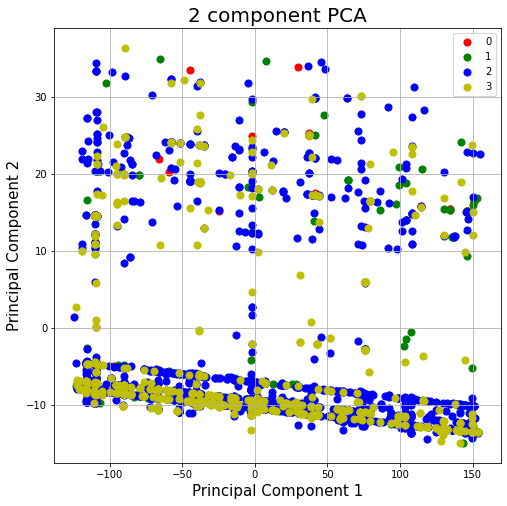

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2, 3]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Niveau_Risque_LAB_FT'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()



---



---



Kmeans Clustering 

In [ ]:
# Kmeans Clustering 

#selecting features :
x = finalDf.iloc[:,0:2] # 1t for rows and second for columns
x

,principal component 1,principal component 2
0,-38.265833,-6.215159
1,-1.549078,29.712306
2,-33.266932,-6.318529
3,71.348233,25.591151
4,71.673602,-9.581805
...,...,...
2936,-115.413015,-9.616893
2937,-107.250932,-4.840214
2938,-109.301710,-6.358432
2939,149.579092,-13.558869


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    max_iter=300,
    random_state=42
    )

In [ ]:
kmeans.fit(x)


KMeans(init='random', n_clusters=4, random_state=42)

In [ ]:
identified_clusters = kmeans.fit_predict(x)
identified_clusters


array([1, 1, 1, ..., 3, 2, 3], dtype=int32)

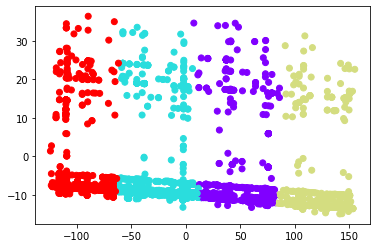

In [ ]:
data_with_clusters = finalDf.copy()
data_with_clusters['Clusters'] = identified_clusters 
plt.scatter(data_with_clusters['principal component 1'],data_with_clusters['principal component 2'],c=data_with_clusters['Clusters'],cmap='rainbow')



---



---



In [ ]:
from collections import Counter

print(Counter(identified_clusters).keys() )# equals to list(set(words))
print(Counter(identified_clusters).values()) # counts the elements' frequency

dict_keys([1, 0, 3, 2])
dict_values([765, 955, 799, 422])


In [ ]:
len(identified_clusters)

2941

In [ ]:
dfidentified_clusters = pd.DataFrame({'identified_clusters':identified_clusters})
dfidentified_clusters

,identified_clusters
0,1
1,1
2,1
3,0
4,0
...,...
2936,3
2937,3
2938,3
2939,2


In [ ]:
finalDf

,principal component 1,principal component 2,Niveau_Risque_LAB_FT
0,-38.265833,-6.215159,2
1,-1.549078,29.712306,2
2,-33.266932,-6.318529,2
3,71.348233,25.591151,2
4,71.673602,-9.581805,3
...,...,...,...
2936,-115.413015,-9.616893,2
2937,-107.250932,-4.840214,2
2938,-109.301710,-6.358432,1
2939,149.579092,-13.558869,3


In [ ]:
result = pd.concat([finalDf, dfidentified_clusters], axis=1)
result

,principal component 1,principal component 2,Niveau_Risque_LAB_FT,identified_clusters
0,-38.265833,-6.215159,2,1
1,-1.549078,29.712306,2,1
2,-33.266932,-6.318529,2,1
3,71.348233,25.591151,2,0
4,71.673602,-9.581805,3,0
...,...,...,...,...
2936,-115.413015,-9.616893,2,3
2937,-107.250932,-4.840214,2,3
2938,-109.301710,-6.358432,1,3
2939,149.579092,-13.558869,3,2


In [ ]:
result['Niveau_Risque_LAB_FT'].value_counts()

2    1813
3     623
1     382
0     123
Name: Niveau_Risque_LAB_FT, dtype: int64

In [ ]:
for i in [0,1,2,3]:
  UniqueC = result[result['identified_clusters']==i]

  print(UniqueC['Niveau_Risque_LAB_FT'].value_counts())


2    487
1    225
3    149
0     94
Name: Niveau_Risque_LAB_FT, dtype: int64
2    525
3    171
1     55
0     14
Name: Niveau_Risque_LAB_FT, dtype: int64
2    254
3    106
1     54
0      8
Name: Niveau_Risque_LAB_FT, dtype: int64
2    547
3    197
1     48
0      7
Name: Niveau_Risque_LAB_FT, dtype: int64




---



---



In [ ]:
train

,Categorie,Tranche_Age,Tranche_Anciennete,Secteur_Activite,Politiquement_Expose,Niveau_Risque_LAB_FT,Code_Nationalite,Ville
0,1,4,2,1,0.0,2,44,193
1,1,4,2,1,0.0,2,6,157
2,1,4,2,1,0.0,2,44,188
3,0,4,2,11,0.0,2,6,84
4,0,4,3,5,0.0,3,44,83
...,...,...,...,...,...,...,...,...
2936,0,4,5,20,0.0,2,44,270
2937,1,4,5,1,0.0,2,44,262
2938,0,4,5,7,0.0,1,44,264
2939,0,4,5,14,0.0,3,44,5


### * Resampling Using SMOTE

In [ ]:
X = train.drop(labels = ['Niveau_Risque_LAB_FT'],axis = 1)
y = train['Niveau_Risque_LAB_FT']

X_test = test.drop(labels = ['Niveau_Risque_LAB_FT'],axis = 1)
y_test = test['Niveau_Risque_LAB_FT']
 
print('Before Resampling train: ','\n\n',y.value_counts())

print('Before Resampling test: ','\n\n',y_test.value_counts())

Before Resampling train:  

 2    1810
3     623
1     381
0     123
Name: Niveau_Risque_LAB_FT, dtype: int64
Before Resampling test:  

 2    411
3    165
1    124
0     35
Name: Niveau_Risque_LAB_FT, dtype: int64


In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('After Resampling train: ','\n\n',y_res.value_counts())
print('After Resampling test: ','\n\n',y_test.value_counts())

After Resampling train:  

 2    1810
3    1810
1    1810
0    1810
Name: Niveau_Risque_LAB_FT, dtype: int64
After Resampling test:  

 2    411
3    165
1    124
0     35
Name: Niveau_Risque_LAB_FT, dtype: int64


In [ ]:
X_train = X_res
y_train = y_res



---



---



#### Visualization of Results

In [ ]:
v = y.value_counts().rename_axis('Risk_Level').reset_index(name='Count Of Clients')


In [ ]:
v

,Risk_Level,Count Of Clients
0,2,1810
1,3,623
2,1,381
3,0,123


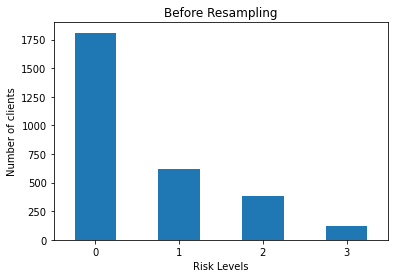

In [ ]:
v = y.value_counts().rename_axis('Risk_Level').reset_index(name='Count Of Clients')
plt.title('Before Resampling')
plt.xlabel('Risk Levels')
plt.ylabel('Number of clients')
v['Count Of Clients'].plot.bar(rot=0)

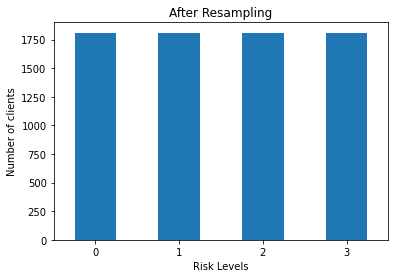

In [ ]:
v = y_train.value_counts().rename_axis('Risk_Level').reset_index(name='Count Of Clients')
plt.title('After Resampling')
plt.xlabel('Risk Levels')
plt.ylabel('Number of clients')
v['Count Of Clients'].plot.bar(rot=0)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7240 entries, 0 to 7239
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Categorie                      7240 non-null   int64  
 1   Tranche_Age                    7240 non-null   int64  
 2   Tranche_Anciennete             7240 non-null   int64  
 3   Secteur_Activite               7240 non-null   int64  
 4   Politiquement_Expose           7240 non-null   float64
 5   Code_Nationalite               7240 non-null   int64  
 6   Ville                          7240 non-null   int64  
 7   CountRibBénéficiaire           7240 non-null   float64
 8   CountBankBénéficiaire          7240 non-null   float64
 9   MinTransactionsDay             7240 non-null   float64
 10  MinTransactionsWeek            7240 non-null   float64
 11  MinTransactionsMonth           7240 non-null   float64
 12  MinTransactionsQuarter         7240 non-null   f

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 0 to 734
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Categorie                      735 non-null    int64  
 1   Tranche_Age                    735 non-null    int64  
 2   Tranche_Anciennete             735 non-null    int64  
 3   Secteur_Activite               735 non-null    int64  
 4   Politiquement_Expose           735 non-null    float64
 5   Code_Nationalite               735 non-null    int64  
 6   Ville                          735 non-null    int64  
 7   CountRibBénéficiaire           735 non-null    float64
 8   CountBankBénéficiaire          735 non-null    float64
 9   MinTransactionsDay             735 non-null    float64
 10  MinTransactionsWeek            735 non-null    float64
 11  MinTransactionsMonth           735 non-null    float64
 12  MinTransactionsQuarter         735 non-null    flo

# Modelling 

### Accuracy scores and normalized confusion matrices with different algorithms

In [ ]:
names = [ "Logistic Regression", "Nearest Neighbors", "Naive Bayes","Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting", 
         "LDA", "QDA", "Neural Net", "LightGBM", "XGBoost" ]    
        
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(5),
    GaussianNB(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(alpha=1, max_iter=1000),
    lgb.LGBMClassifier(),    
    xgb.XGBClassifier()
   ]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression
accuracy_scores :  0.28
balanced_accuracy_score :  0.45


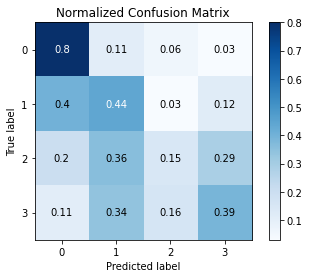

Nearest Neighbors
accuracy_scores :  0.33
balanced_accuracy_score :  0.25


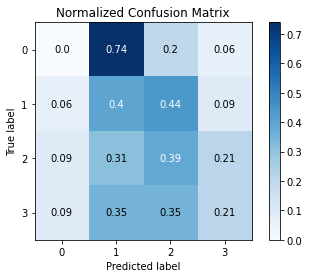

Naive Bayes
accuracy_scores :  0.37
balanced_accuracy_score :  0.39


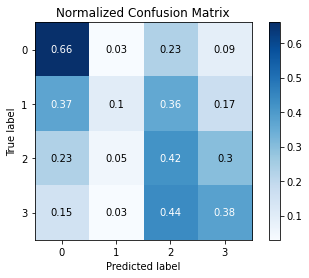

Decision Tree
accuracy_scores :  0.13
balanced_accuracy_score :  0.20


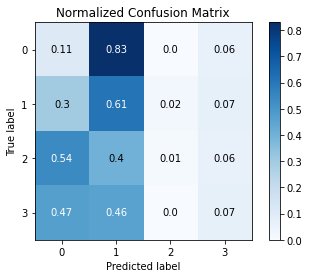

Random Forest
accuracy_scores :  0.39
balanced_accuracy_score :  0.48


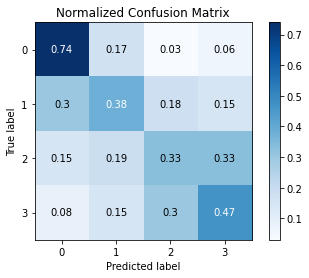

AdaBoost
accuracy_scores :  0.19
balanced_accuracy_score :  0.25


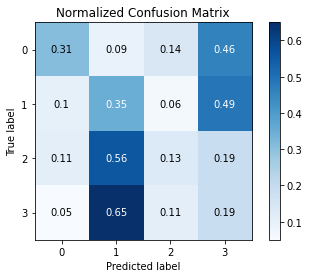

Gradient Boosting
accuracy_scores :  0.29
balanced_accuracy_score :  0.26


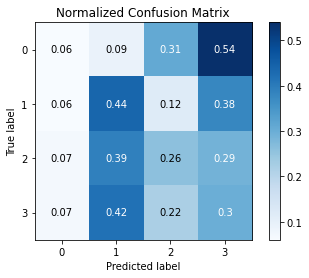

LDA
accuracy_scores :  0.23
balanced_accuracy_score :  0.43


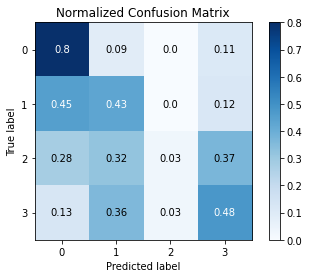

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA
accuracy_scores :  0.31
balanced_accuracy_score :  0.33


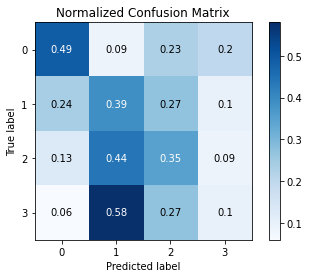

Neural Net
accuracy_scores :  0.39
balanced_accuracy_score :  0.49


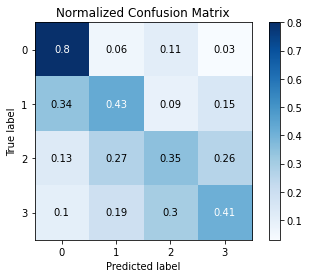

LightGBM
accuracy_scores :  0.34
balanced_accuracy_score :  0.26


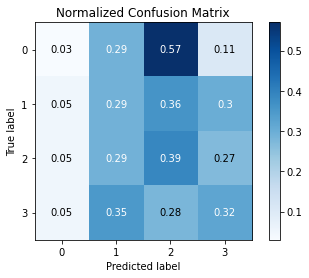

XGBoost
accuracy_scores :  0.33
balanced_accuracy_score :  0.40


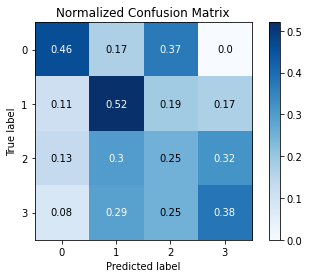

support vector machines: Polynomial kernel 
accuracy_scores :  0.05
balanced_accuracy_score :  0.25


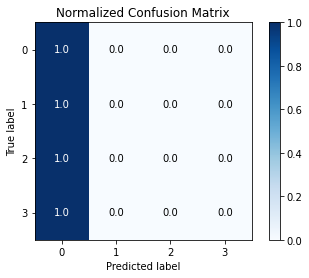

support vector machines: RBF kernel 
accuracy_scores :  0.22
balanced_accuracy_score :  0.25


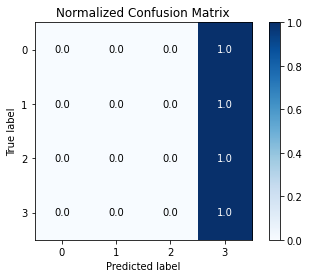

In [ ]:

accuracy_scores = []
balanced_accuracy_scores=[]
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    
    #normal score: 
    score = clf.score(X_test, y_test)
    score = round(score, 4)
    accuracy_scores.append(score)
    print(name)
    print('accuracy_scores : ' , "%.2f" % (score))
    #Generate predictions with the model using our X values
    y_pred = clf.predict(X_test)

    #Balanced Accuracy Score:
    balanced_accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
    print('balanced_accuracy_score : ' , "%.2f" % (balanced_accuracy_score(y_test, y_pred)))

    #Get the normalized confusion matrix
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    plt.show()


rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)

# Poly visualisation:
print('support vector machines: Polynomial kernel ')
#accuracy_scores
poly_accuracy = accuracy_score(y_test, poly_pred)
accuracy_scores.append(poly_accuracy)
print('accuracy_scores : ', "%.2f" % (poly_accuracy))
#Balanced Accuracy Score:
balanced_accuracy_scores.append(balanced_accuracy_score(y_test, poly_pred))
print('balanced_accuracy_score : ' , balanced_accuracy_score(y_test, poly_pred))

#Get the normalized confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, poly_pred, normalize=True)
plt.show()


# Rbf visualisation :
print('support vector machines: RBF kernel ')
#accuracy_scores
rbf_accuracy = accuracy_score(y_test, rbf_pred)
accuracy_scores.append(rbf_accuracy)
print('accuracy_scores : ', "%.2f" % (rbf_accuracy))
#Balanced Accuracy Score:
balanced_accuracy_scores.append(balanced_accuracy_score(y_test, rbf_pred))
print('balanced_accuracy_score : ' , balanced_accuracy_score(y_test, rbf_pred))

#Get the normalized confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, rbf_pred, normalize=True)
plt.show()

names.append("SVM Polynomial")
names.append("SVM RBF")





---



Plot the classifier accuracy scores

In [ ]:
DfAccuracy_scores = pd.DataFrame({"Classifiers": names, "Accuracy Scores": accuracy_scores})
DfBalanced_accuracy_scores = pd.DataFrame({"Classifiers": names, "Balanced Accuracy Scores": balanced_accuracy_scores})

DfAccuracy_scores=DfAccuracy_scores.sort_values(by = 'Accuracy Scores' , ascending = False)[['Classifiers', 'Accuracy Scores']]
DfBalanced_accuracy_scores=DfBalanced_accuracy_scores.sort_values(by = 'Balanced Accuracy Scores' , ascending = False)[['Classifiers', 'Balanced Accuracy Scores']]

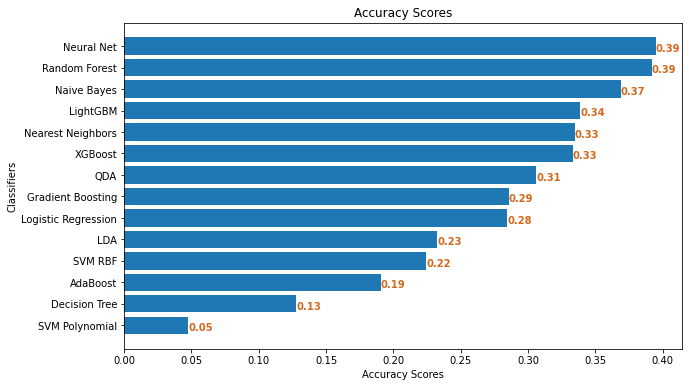

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
x = DfAccuracy_scores['Accuracy Scores']
y = DfAccuracy_scores['Classifiers']
ax.barh(y, x, align='center')

for i, v in enumerate(x):
    ax.text(v, i + .25, str(float("{:.2f}".format(v))),
            color = 'chocolate', fontweight = 'bold')

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy Scores')
ax.set_ylabel('Classifiers', rotation=90)
ax.set_title('Accuracy Scores')
plt.show()

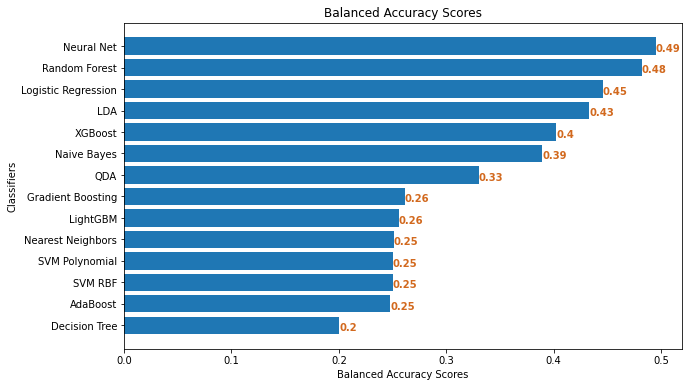

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
x = DfBalanced_accuracy_scores['Balanced Accuracy Scores']
y = DfBalanced_accuracy_scores['Classifiers']
ax.barh(y, x, align='center')

for i, v in enumerate(x):
    ax.text(v, i + .25, str(float("{:.2f}".format(v))),
            color = 'chocolate', fontweight = 'bold')

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Balanced Accuracy Scores')
ax.set_ylabel('Classifiers', rotation=90)
ax.set_title('Balanced Accuracy Scores')
plt.show()



---



### Learning Curves:

In [ ]:
X_combined = pd.concat([X_train, X_test])

y_combined = y_train.append(y_test)

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring='balanced_accuracy'
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


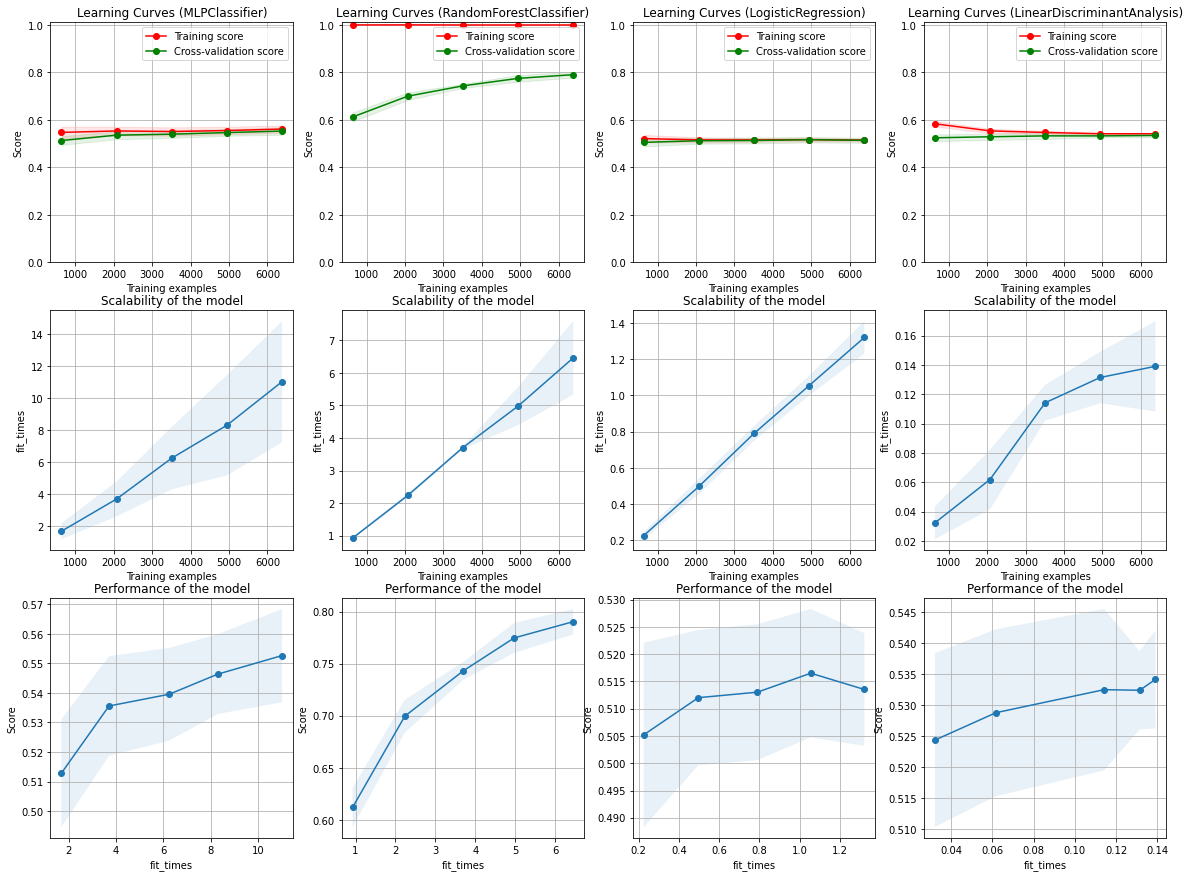

In [ ]:

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

X = X_combined
y = y_combined

title = "Learning Curves (MLPClassifier)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = MLPClassifier(alpha=1, max_iter=1000)
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (RandomForestClassifier)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0, 1.01), cv=cv, n_jobs=4
)

title = "Learning Curves (LogisticRegression)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = LogisticRegression()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 2], ylim=(0, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (LinearDiscriminantAnalysis)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = LinearDiscriminantAnalysis()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 3], ylim=(0, 1.01), cv=cv, n_jobs=4
)


plt.show()

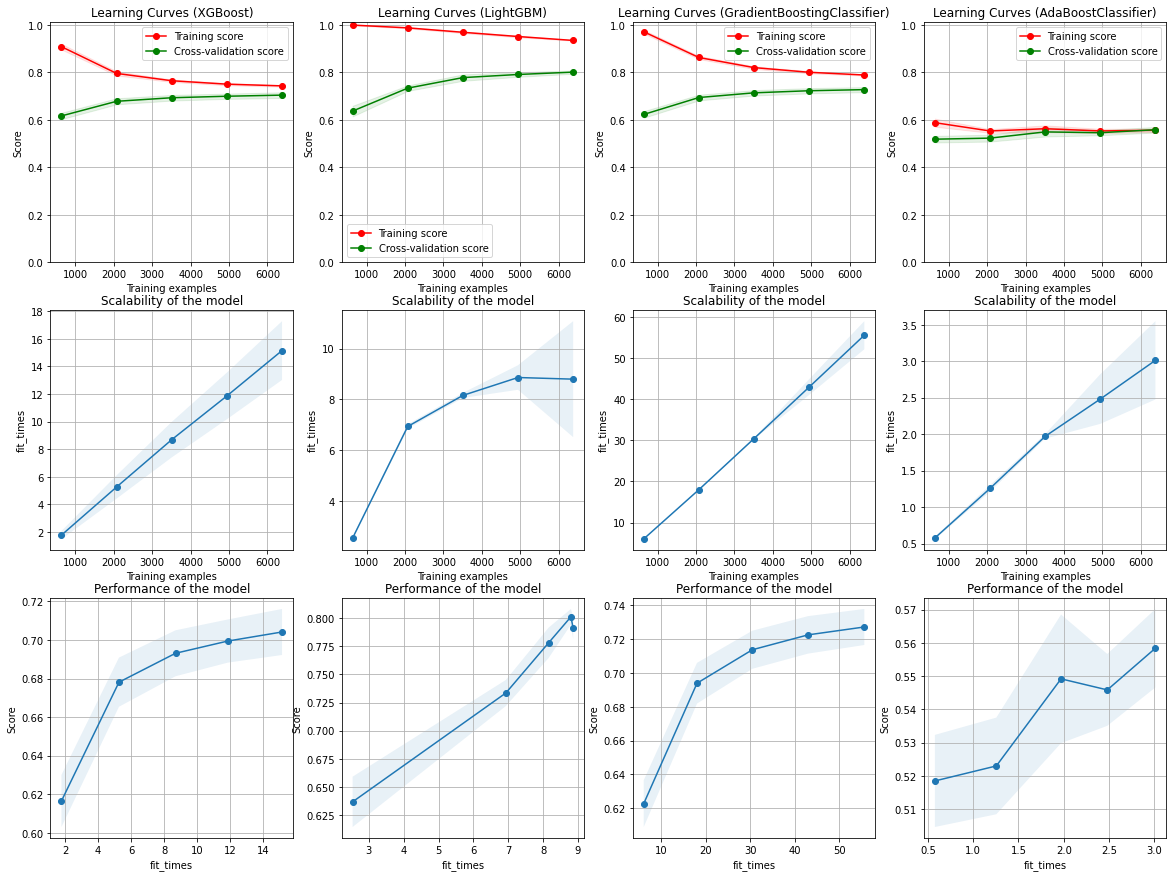

In [ ]:

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

X = X_combined
y = y_combined

title = "Learning Curves (XGBoost)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = xgb.XGBClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (LightGBM)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = lgb.LGBMClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0, 1.01), cv=cv, n_jobs=4
)

title = "Learning Curves (GradientBoostingClassifier)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = GradientBoostingClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 2], ylim=(0, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (AdaBoostClassifier)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = AdaBoostClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 3], ylim=(0, 1.01), cv=cv, n_jobs=4
)


plt.show()

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


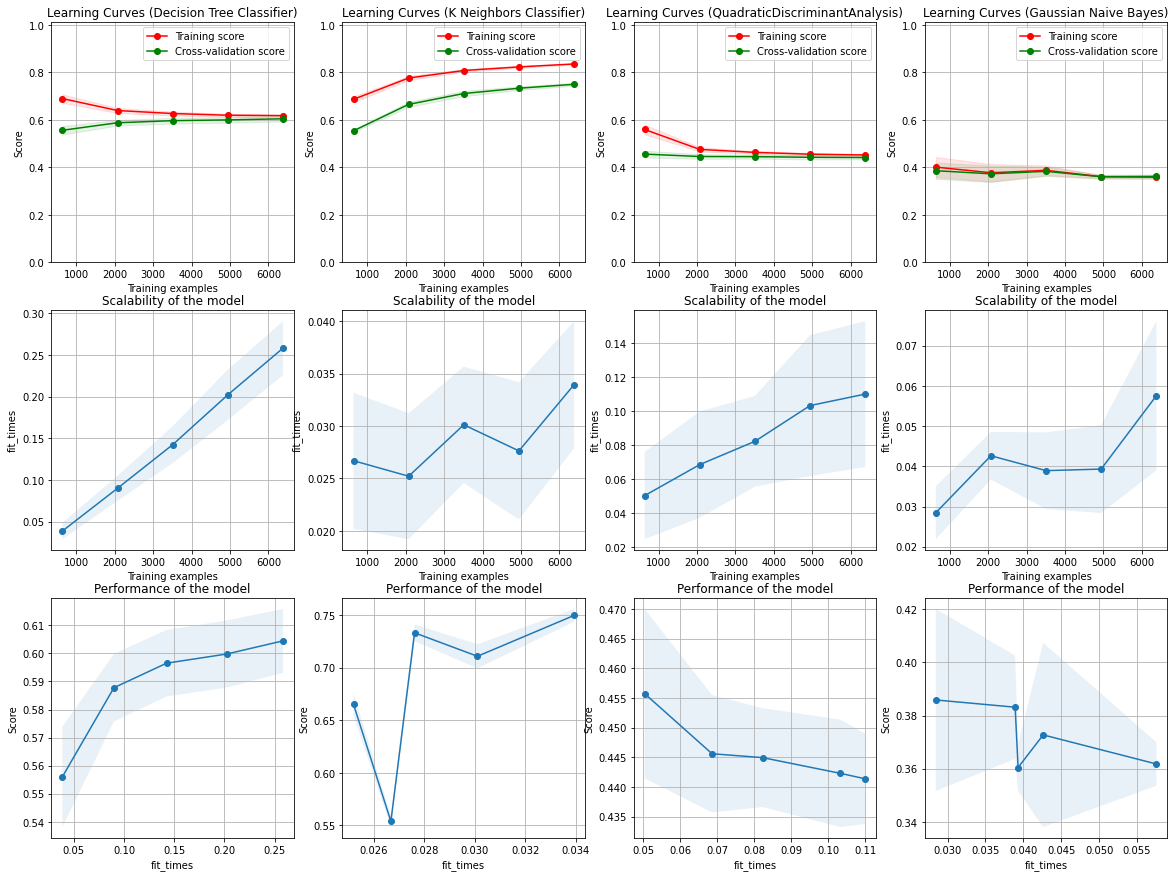

In [ ]:

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

X = X_combined
y = y_combined

title = "Learning Curves (Decision Tree Classifier)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = DecisionTreeClassifier(max_depth=5)
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (K Neighbors Classifier)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = KNeighborsClassifier(5)
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0, 1.01), cv=cv, n_jobs=4
)

title = "Learning Curves (QuadraticDiscriminantAnalysis)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = QuadraticDiscriminantAnalysis()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 2], ylim=(0, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (Gaussian Naive Bayes)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = GaussianNB()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 3], ylim=(0, 1.01), cv=cv, n_jobs=4
)


plt.show()



---



---



---



### Feature Selection

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7240 entries, 0 to 7239
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Categorie                      7240 non-null   int64  
 1   Tranche_Age                    7240 non-null   int64  
 2   Tranche_Anciennete             7240 non-null   int64  
 3   Secteur_Activite               7240 non-null   int64  
 4   Politiquement_Expose           7240 non-null   float64
 5   Code_Nationalite               7240 non-null   int64  
 6   Ville                          7240 non-null   int64  
 7   CountRibBénéficiaire           7240 non-null   float64
 8   CountBankBénéficiaire          7240 non-null   float64
 9   MinTransactionsQuarter         7240 non-null   float64
 10  MaxTransactionsQuarter         7240 non-null   float64
 11  MeanTransactionsQuarter        7240 non-null   float64
 12  Ecart-typeTransactionsQuarter  7240 non-null   f

In [ ]:
# Logistic regression :

from functools import lru_cache

LRname = ["Logistic Regression" ]    

LR = [
    LogisticRegression()
   ]
x=[]
for name, clf in zip(LRname, LR):
    print(name)
    clf.fit(X_train, y_train)
    

    feature_importance=[]
    for i in clf.coef_[0]:
      feature_importance.append(pow(math.e, i))


    x=feature_importance
    y=X_train.columns

    #print(x)
    #print(y)  

Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
LogisticRegression = ['{0:.3f}'.format(i) for i in x]
LogisticRegression = pd.DataFrame(LogisticRegression, columns = ['LogisticRegression'])
LogisticRegression = preprocessing.MinMaxScaler().fit_transform(LogisticRegression)
LogisticRegression = pd.DataFrame(LogisticRegression, columns = ['LogisticRegression'])
#LogisticRegression



---



---



In [ ]:
#Random Forest :

RFname = ["Random Forest" ]    

RF = [
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
   ]

for name, clf in zip(RFname, RF):
    print(name)
    clf.fit(X_train, y_train)

    feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns)

    x=feature_scores.values
    y=feature_scores.index

   # print(x)
   # print(y)






Random Forest


In [ ]:
RandomForestClassifier = ['{0:.3f}'.format(i) for i in x]
RandomForestClassifier = pd.DataFrame(RandomForestClassifier, columns = ['RandomForestClassifier'])
RandomForestClassifier = preprocessing.MinMaxScaler().fit_transform(RandomForestClassifier)
RandomForestClassifier = pd.DataFrame(RandomForestClassifier, columns = ['RandomForestClassifier'])
#RandomForestClassifier



---



---



In [ ]:
# Linear Discriminant Analysis :

from functools import lru_cache

LDAname = ["Linear Discriminant Analysis" ]    

LDA = [
    LinearDiscriminantAnalysis()
   ]
x=[]
for name, clf in zip(LDAname, LDA):
    print(name)
    clf.fit(X_train, y_train)
    

    feature_importance=[]
    for i in clf.coef_[0]:
      feature_importance.append(pow(math.e, i))


    x=feature_importance
    y=X_train.columns

   # print(x)
   # print(y)  

Linear Discriminant Analysis


In [ ]:
# x contains alot of infinite numbers that needs to be transformed : 

dfx= pd.DataFrame(x)
x=dfx[0]

from numpy import inf
x[x == inf] = 1

In [ ]:
LinearDiscriminantAnalysis = ['{0:.3f}'.format(i) for i in x]
LinearDiscriminantAnalysis = pd.DataFrame(LinearDiscriminantAnalysis, columns = ['LinearDiscriminantAnalysis'])

#LinearDiscriminantAnalysis= LinearDiscriminantAnalysis.replace([np.inf], 1, inplace=True)
#LinearDiscriminantAnalysis=LinearDiscriminantAnalysis.fillna(0, inplace=True)

LinearDiscriminantAnalysis = preprocessing.MinMaxScaler().fit_transform(LinearDiscriminantAnalysis)
LinearDiscriminantAnalysis = pd.DataFrame(LinearDiscriminantAnalysis, columns = ['LinearDiscriminantAnalysis'])
#LinearDiscriminantAnalysis

In [ ]:
y=y.to_frame(index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


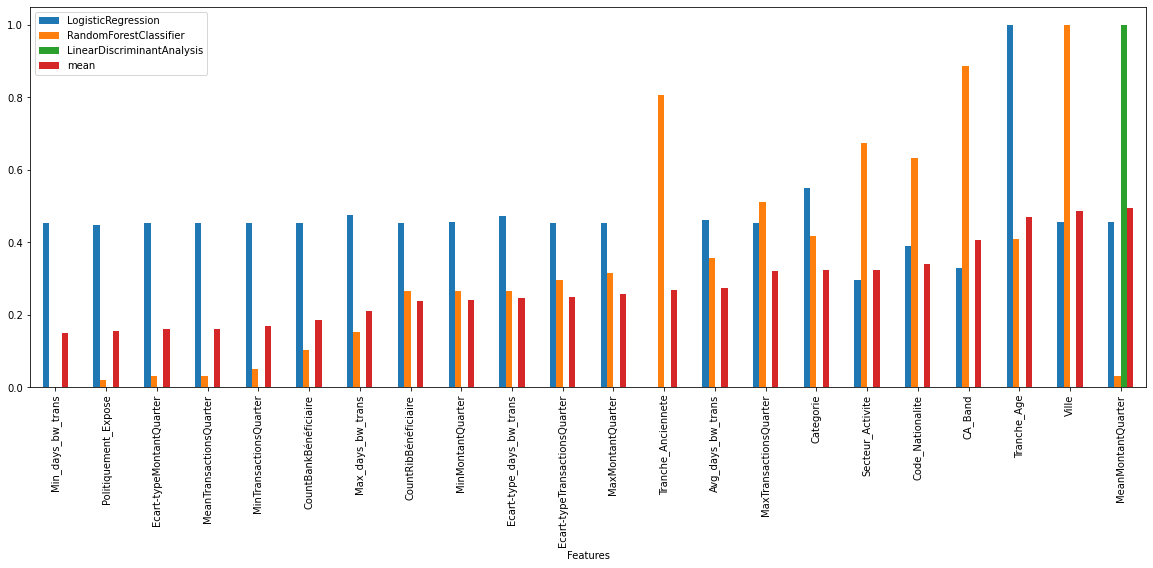

In [ ]:
importance_df = pd.concat( [y,LogisticRegression,RandomForestClassifier,LinearDiscriminantAnalysis], axis=1)
importance_df['mean'] = importance_df.mean(axis=1)
importance_df.reset_index(drop=True, inplace=True)
importance_df=importance_df.rename(columns={0: "Features"})
importance_df.sort_values('mean').plot(x='Features',kind='bar', figsize=(20, 7))



---



---



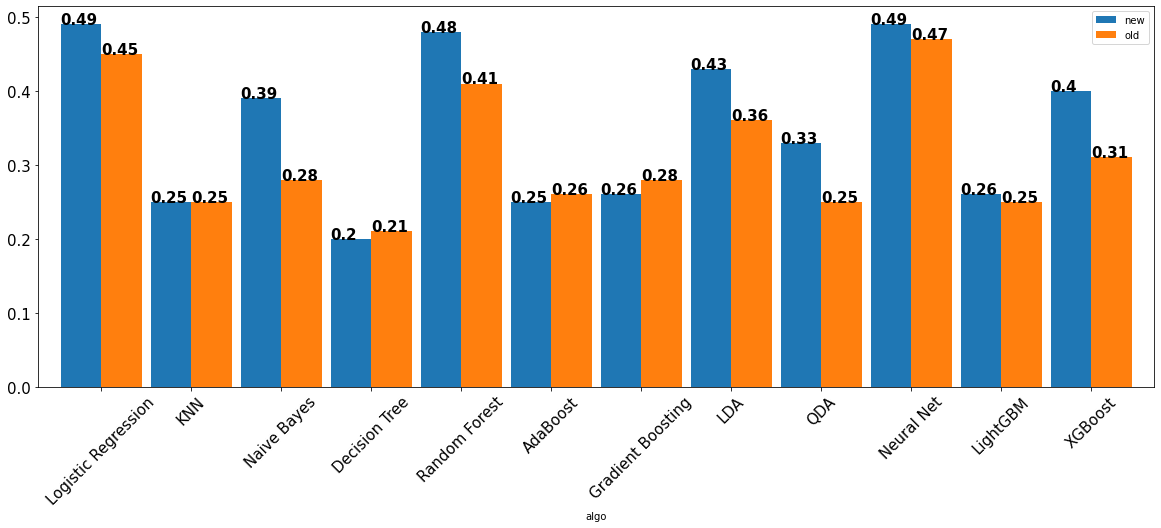

In [ ]:
new=pd.DataFrame([0.49,0.25,0.39,0.2,0.48,0.25,0.26,0.43,0.33,0.49,0.26,0.4]).rename(columns={0: "new"})
old=pd.DataFrame([0.45,0.25,0.28,0.21,0.41,0.26,0.28,0.36,0.25,0.47,0.25,0.31]).rename(columns={0: "old"})
algo=pd.DataFrame(["Logistic Regression", "KNN", "Naive Bayes","Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting", 
         "LDA", "QDA", "Neural Net", "LightGBM", "XGBoost" ]).rename(columns={0: "algo"})

dd = pd.concat( [algo,new,old], axis=1)


ax = dd.plot(x='algo', kind='bar', figsize=(20, 7), width=0.9, rot=45,  fontsize = 15) 

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.0, p.get_height() * 1.00) ,color = 'black', fontweight = 'bold',  fontsize = 15 )

### Cross Validation with default parameters 

CV teta3mal b X w Y mouch train

In [ ]:
X_combined = np.r_[X_train, X_test]
y_combined = np.r_[y_train, y_test]

X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)

In [ ]:
names2 = [ "Logistic Regression","Random Forest",
         "LDA", "Neural Net" ]    
        
classifiers2 = [
    LogisticRegression(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    LinearDiscriminantAnalysis(),
    MLPClassifier(alpha=1, max_iter=1000)

   ]


from sklearn.model_selection import cross_val_score

names2 = [  "Nearest Neighbors", "Gradient Boosting", "LightGBM", "XGBoost" ]           
classifiers2 = [
    KNeighborsClassifier(5),
    GradientBoostingClassifier(),
    lgb.LGBMClassifier(),    
    xgb.XGBClassifier()
   ]

In [ ]:
CrossValScore =[]
for name, clf in zip(names2, classifiers2):
    scores = cross_val_score(clf, X_combined, y_combined, cv = 10, scoring='balanced_accuracy')
    CrossValScore.append('{:.4f}'.format(scores.mean()))
    print(name , ':{:.4f}'.format(scores.mean()))

In [ ]:
CVS = [float(i) for i in CrossValScore]

CVS


[0.5059, 0.492, 0.5209, 0.5546]

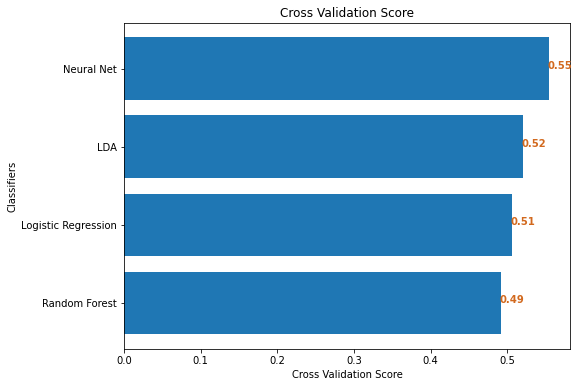

In [ ]:
CrossValidation = {'Classifier':[  "Logistic Regression","Random Forest", "LDA","Neural Net" ],
         'Cross Validation Score':CVS
                   }
CrossValidation = pd.DataFrame(CrossValidation)      
CrossValidation=CrossValidation.sort_values(by = 'Cross Validation Score' , ascending = False)[['Classifier', 'Cross Validation Score']]

fig, ax = plt.subplots(figsize=(8,6))
x = CrossValidation['Cross Validation Score']
y = CrossValidation['Classifier']
ax.barh(y, x, align='center')

for i, v in enumerate(x):
    ax.text(v-0.0019, i , str(float("{:.2f}".format(v))),
            color = 'chocolate', fontweight = 'bold')

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Cross Validation Score')
ax.set_ylabel('Classifiers', rotation=90)
ax.set_title('Cross Validation Score')
plt.show()

        



---



### Hyperparameter Optimization using GridSearch CV

In [ ]:
names = [ "Logistic Regression","Random Forest",
         "LDA", "Neural Net" ]    
        
classifiers = [
    LogisticRegression(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    LinearDiscriminantAnalysis(),
    MLPClassifier(alpha=1, max_iter=1000)

   ]



---



---



In [ ]:
# Random Forest Classifier :
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200,500,800,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,7,10,13,15],
    'criterion' :['entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,scoring='balanced_accuracy' )
CV_rfc.fit(X_train, y_train)

# best score achieved during the GridSearchCV
print('RandomForestClassifier GridSearch CV best score : {:.4f}\n\n'.format(CV_rfc.best_score_))

# print parameters that give the best results
print('RandomForestClassifier Parameters that give the best results :','\n\n', (CV_rfc.best_params_))

# print estimator that was chosen by the GridSearch
rfc_best = CV_rfc.best_estimator_
print('\n\RandomForestClassifier Estimator that was chosen by the search :','\n\n', (rfc_best))

RandomForestClassifier GridSearch CV best score : 0.7943


RandomForestClassifier Parameters that give the best results : 

 {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 1000}

\RandomForestClassifier Estimator that was chosen by the search : 

 RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=1000,
                       random_state=42)


RandomForestClassifier GridSearch CV best score : 0.7818


RandomForestClassifier Parameters that give the best results : 

 {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 700}

\RandomForestClassifier Estimator that was chosen by the search : 

 RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=700,
                       random_state=42)



---



---



In [ ]:
# Logistic Regression 

LR = LogisticRegression()
solvers = ['newton-cg']
penalty = ['l2']
max_iter=[10,100,1000]
c_values = [10, 1.0, 0.1]
# define grid search
LR_params = dict(solver=solvers,penalty=penalty,C=c_values)

CV_LR = GridSearchCV(estimator=LR, param_grid=LR_params, cv=5, scoring='balanced_accuracy')
CV_LR.fit(X_train, y_train)

# best score achieved during the GridSearchCV
print('Logistic Regression GridSearch CV best score : {:.4f}\n\n'.format(CV_LR.best_score_))

# print parameters that give the best results
print('Logistic Regression Parameters that give the best results :','\n\n', (CV_LR.best_params_))

# print estimator that was chosen by the GridSearch
LR_best = CV_LR.best_estimator_
print('\n\Logistic Regression Estimator that was chosen by the search :','\n\n', (LR_best))

Logistic Regression GridSearch CV best score : 0.5412


Logistic Regression Parameters that give the best results : 

 {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

\Logistic Regression Estimator that was chosen by the search : 

 LogisticRegression(C=10, solver='newton-cg')


Logistic Regression Parameters that give the best results : 

 {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

\Logistic Regression Estimator that was chosen by the search : 

 LogisticRegression(C=10, solver='newton-cg')



---



---



In [ ]:
# Linear Discriminant Analysis 

LDA = LinearDiscriminantAnalysis()

# Search grid for optimal parameters
lda_param_grid = {
    'solver' : ['svd'],
    'tol' : [0.0001,0.0002],
    'shrinkage' : [0 , 0.05 , 0.1 ,0.5 , 0.9] 
    }


gsLDA = GridSearchCV(LDA, param_grid = lda_param_grid, cv=5,
                     scoring="balanced_accuracy")

gsLDA.fit(X_train,y_train)

# best score achieved during the GridSearchCV
print('Linear Discriminant Analysis GridSearch CV best score : {:.4f}\n\n'.format(gsLDA.best_score_))

# print parameters that give the best results
print('Linear Discriminant Analysis Parameters that give the best results :','\n\n', (gsLDA.best_params_))

# print estimator that was chosen by the GridSearch
LDA_best = gsLDA.best_estimator_
print('\n\Linear Discriminant Analysis Estimator that was chosen by the search :','\n\n', (LDA_best))

Linear Discriminant Analysis GridSearch CV best score : 0.5296


Linear Discriminant Analysis Parameters that give the best results : 

 {'solver': 'svd', 'tol': 0.0001}

\Linear Discriminant Analysis Estimator that was chosen by the search : 

 LinearDiscriminantAnalysis()



---



In [ ]:
# Neural Network == MLPClassifier

mlp = MLPClassifier(max_iter=100)

parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05,0.1],
    'learning_rate': ['constant'],
}

gsMLPC = GridSearchCV(mlp, parameter_space, cv=5)

gsMLPC.fit(X_train,y_train)

# best score achieved during the GridSearchCV
print('MLPClassifier GridSearch CV best score : {:.4f}\n\n'.format(gsMLPC.best_score_))

# print parameters that give the best results
print('MLPClassifier Parameters that give the best results :','\n\n', (gsMLPC.best_params_))

# print estimator that was chosen by the GridSearch
MLPC_best = gsMLPC.best_estimator_
print('\n\MLPClassifier Estimator that was chosen by the search :','\n\n', (MLPC_best))

MLPClassifier GridSearch CV best score : 0.5641


MLPClassifier Parameters that give the best results : 

 {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}

\MLPClassifier Estimator that was chosen by the search : 

 MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=(20,),
              max_iter=100)

Visualization :

new=pd.DataFrame([0.51,0.51,0.45,0.44]).rename(columns={0: "new"})
old=pd.DataFrame([0.78,0.54,0.53,0.52]).rename(columns={0: "old"})
algo=pd.DataFrame(["Random Forest","Neural Net","Logistic Regression", "LDA"]).rename(columns={0: "algo"})

dd = pd.concat( [algo,new,old], axis=1)


ax = dd.plot(x='algo', kind='bar', figsize=(20, 7), rot=0) 

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.04, p.get_height() * 1.005) ,color = 'black', fontweight = 'bold' )



---



---



### Accuracy scores and normalized confusion matrices with optimized parameters

In [ ]:
names =  [ "Logistic Regression","Random Forest",
         "LDA", "Neural Net" ] 
        
classifiers = [
    LogisticRegression(C=10, solver='newton-cg'),
    #RandomForestClassifier(criterion='entropy', max_depth=6,  n_estimators=64,random_state=1 ), # DONE 
    RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=700, random_state=42),
    LinearDiscriminantAnalysis(shrinkage=0, solver='lsqr'),
    MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=(20,), max_iter=100)

   ]

Logistic Regression
accuracy_scores :  0.2422
balanced_accuracy_score :  0.4430370635956933


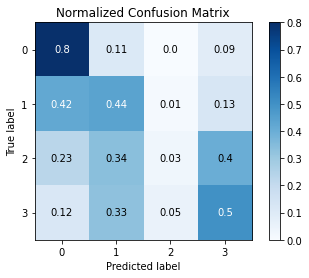

Random Forest
accuracy_scores :  0.4463
balanced_accuracy_score :  0.33886128685693084


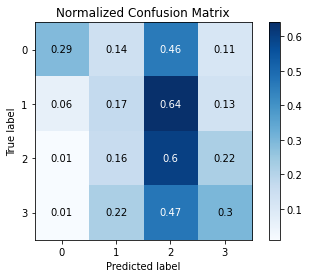

LDA
accuracy_scores :  0.249
balanced_accuracy_score :  0.45172800866820173


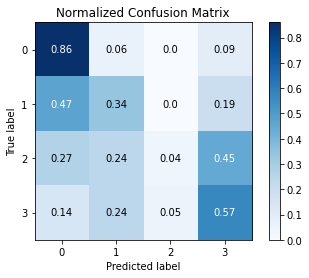

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Neural Net
accuracy_scores :  0.3469
balanced_accuracy_score :  0.4647922597769549


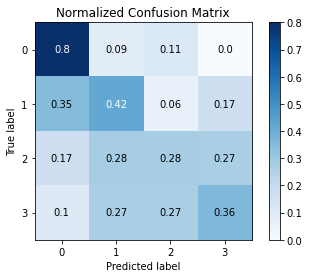

In [ ]:

accuracy_scores = []
balanced_accuracy_scores=[]
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    
    #normal score: 
    score = clf.score(X_test, y_test)
    score = round(score, 4)
    accuracy_scores.append(score)
    print(name)
    print('accuracy_scores : ' , score)
    #Generate predictions with the model using our X values
    y_pred = clf.predict(X_test)

    #Balanced Accuracy Score:
    balanced_accuracy_scores.append(balanced_accuracy_score(y_test, y_pred))
    print('balanced_accuracy_score : ' , balanced_accuracy_score(y_test, y_pred))

    #Get the normalized confusion matrix
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    plt.show()


rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)







---



Plot the classifier accuracy scores

In [ ]:
DfAccuracy_scores = pd.DataFrame({"Classifiers": names, "Accuracy Scores": accuracy_scores})
DfBalanced_accuracy_scores = pd.DataFrame({"Classifiers": names, "Balanced Accuracy Scores": balanced_accuracy_scores})

DfAccuracy_scores=DfAccuracy_scores.sort_values(by = 'Accuracy Scores' , ascending = False)[['Classifiers', 'Accuracy Scores']]
DfBalanced_accuracy_scores=DfBalanced_accuracy_scores.sort_values(by = 'Balanced Accuracy Scores' , ascending = False)[['Classifiers', 'Balanced Accuracy Scores']]

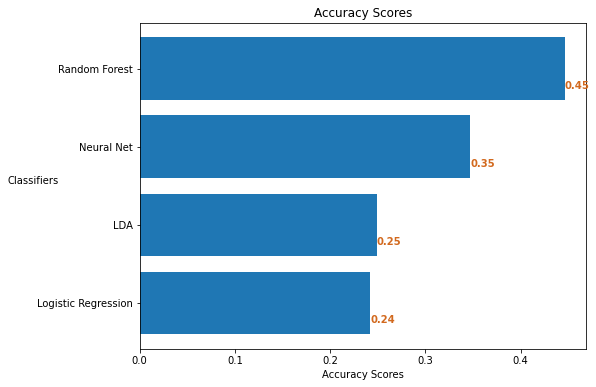

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
x = DfAccuracy_scores['Accuracy Scores']
y = DfAccuracy_scores['Classifiers']
ax.barh(y, x, align='center')

for i, v in enumerate(x):
    ax.text(v, i + .25, str(float("{:.2f}".format(v))),
            color = 'chocolate', fontweight = 'bold')

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy Scores')
ax.set_ylabel('Classifiers', rotation=0)
ax.set_title('Accuracy Scores')
plt.show()

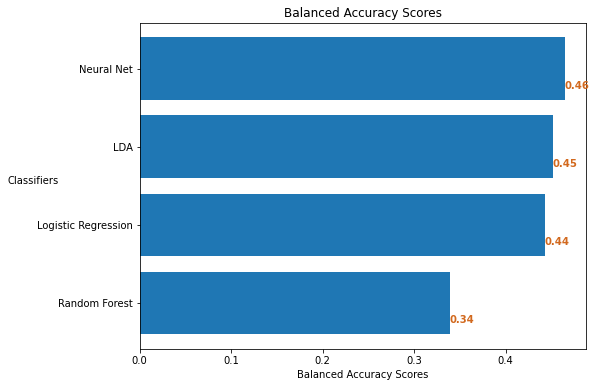

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
x = DfBalanced_accuracy_scores['Balanced Accuracy Scores']
y = DfBalanced_accuracy_scores['Classifiers']
ax.barh(y, x, align='center')

for i, v in enumerate(x):
    ax.text(v, i + .25, str(float("{:.2f}".format(v))),
            color = 'chocolate', fontweight = 'bold')

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Balanced Accuracy Scores')
ax.set_ylabel('Classifiers', rotation=0)
ax.set_title('Balanced Accuracy Scores')
plt.show()



---



### Cross Validation with optimized parameters

CV teta3mal b X w Y mouch train 

In [ ]:
X_combined = np.r_[X_train, X_test]
y_combined = np.r_[y_train, y_test]

X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)

In [ ]:
names2 = [ "Logistic Regression","Random Forest",
         "LDA", "Neural Net" ]    
        
classifiers2 = [
    LogisticRegression(C=10, solver='newton-cg'),
    #RandomForestClassifier(criterion='entropy', max_depth=6,  n_estimators=64,random_state=1 ), # DONE 
    RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=700, random_state=42),
    LinearDiscriminantAnalysis(shrinkage=0, solver='lsqr'),
    MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=(20,), max_iter=100)
   ]

In [ ]:
CrossValScore =[]
for name, clf in zip(names2, classifiers2):
    scores = cross_val_score(clf, X_combined, y_combined, cv = 10, scoring='balanced_accuracy')
    CrossValScore.append('{:.4f}'.format(scores.mean()))
    print(name , ':{:.4f}'.format(scores.mean()))

Logistic Regression :0.5183
Random Forest :0.7763
LDA :0.5160


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Neural Net :0.5384


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
CVS = [float(i) for i in CrossValScore]
CVS

[0.5183, 0.7763, 0.516, 0.5384]

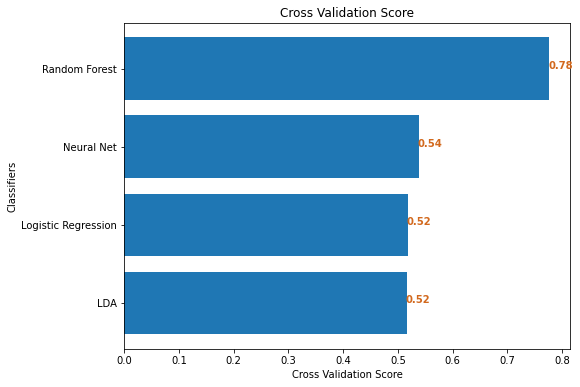

In [ ]:
CrossValidation = {'Classifier':[  "Logistic Regression","Random Forest", "LDA","Neural Net" ],
         'Cross Validation Score':CVS
                   }
CrossValidation = pd.DataFrame(CrossValidation)      
CrossValidation=CrossValidation.sort_values(by = 'Cross Validation Score' , ascending = False)[['Classifier', 'Cross Validation Score']]

fig, ax = plt.subplots(figsize=(8,6))
x = CrossValidation['Cross Validation Score']
y = CrossValidation['Classifier']
ax.barh(y, x, align='center')

for i, v in enumerate(x):
    ax.text(v-0.0019, i , str(float("{:.2f}".format(v))),
            color = 'chocolate', fontweight = 'bold')

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Cross Validation Score')
ax.set_ylabel('Classifiers', rotation=90)
ax.set_title('Cross Validation Score')
plt.show()

        



---



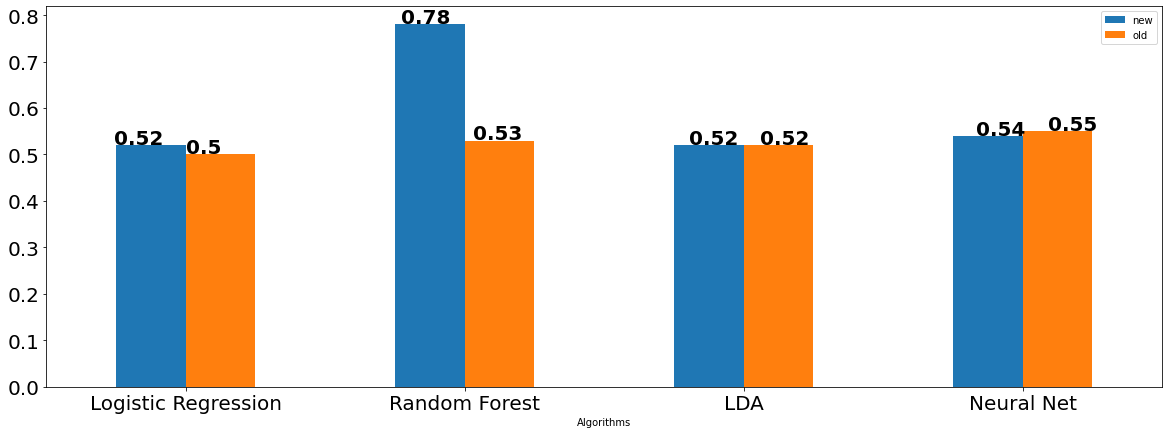

In [ ]:
new=pd.DataFrame([0.52,0.78,0.52,0.54]).rename(columns={0: "new"})
old=pd.DataFrame([0.5,0.53,0.52,0.55]).rename(columns={0: "old"})
algo=pd.DataFrame(["Logistic Regression", "Random Forest", 
         "LDA", "Neural Net" ]).rename(columns={0: "Algorithms"})

dd = pd.concat( [algo,new,old], axis=1)


ax = dd.plot(x='Algorithms', kind='bar', figsize=(20, 7), rot=0,  fontsize = 20 ) 

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.03, p.get_height() * 1.005) ,color = 'black', fontweight = 'bold', fontsize = 20 )

### Save RandomForest Model

In [ ]:
import joblib


In [ ]:
RFC = RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=700,random_state=42).fit(X_train, y_train)


In [ ]:
X_train

,Categorie,Tranche_Age,Tranche_Anciennete,Secteur_Activite,Politiquement_Expose,Code_Nationalite,Ville,CA_Band,CountRibBénéficiaire,MeanTransactionsMonth,MeanTransactionsQuarter,MeanMontantMonth,MeanMontantQuarter,Avg_days_bw_trans
0,1,2,2,0,0.0,44,193,4,0.000000,0.000000,0.000000,0.000073,0.000073,0.000000
1,1,2,2,0,0.0,6,157,4,0.004464,0.000000,0.002712,0.003492,0.003599,0.138549
2,1,2,2,0,0.0,44,188,4,0.000000,0.000000,0.000000,0.000902,0.000913,0.000000
3,0,6,2,1,0.0,6,84,12,0.000000,0.000000,0.000000,0.007352,0.007447,0.000000
4,0,4,3,1,0.0,44,83,3,0.004464,0.000000,0.000000,0.001408,0.001426,0.099022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7247,0,2,4,0,0.0,44,199,3,0.000000,0.000000,0.000000,0.002413,0.002444,0.007629
7248,0,5,5,2,0.0,44,245,11,0.000000,0.001199,0.009451,0.014892,0.015631,0.041456
7249,1,7,4,0,0.0,18,114,4,0.004464,0.000000,0.003243,0.001554,0.001534,0.101509
7250,0,3,1,2,0.0,44,96,3,0.021920,0.010289,0.006360,0.002521,0.002775,0.068897


In [ ]:
import joblib

joblib.dump(RFC, 'RandomForest_Aprroach_Profile_V03.joblib')

['RandomForest_Aprroach_Profile_V03.joblib']

In [ ]:
train


,Categorie,Tranche_Age,Tranche_Anciennete,Secteur_Activite,Politiquement_Expose,Niveau_Risque_LAB_FT,Code_Nationalite,Ville,CA_Band,CountRibBénéficiaire,MeanTransactionsMonth,MeanTransactionsQuarter,MeanMontantMonth,MeanMontantQuarter,Avg_days_bw_trans
0,1,2,2,0,0.0,2,44,193,4,0.000000,0.000000,0.000000,0.000073,0.000073,0.000000
1,1,2,2,0,0.0,2,6,157,4,0.004464,0.000000,0.002712,0.003492,0.003599,0.138549
2,1,2,2,0,0.0,2,44,188,4,0.000000,0.000000,0.000000,0.000902,0.000913,0.000000
3,0,6,2,1,0.0,2,6,84,12,0.000000,0.000000,0.000000,0.007352,0.007447,0.000000
4,0,4,3,1,0.0,3,44,83,3,0.004464,0.000000,0.000000,0.001408,0.001426,0.099022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,0,6,5,1,0.0,2,44,270,13,0.000000,0.000000,0.000000,0.015377,0.015575,0.000000
2937,1,7,5,0,0.0,2,44,262,3,0.000000,0.000000,0.000000,0.000129,0.000130,0.000000
2938,0,6,5,1,0.0,1,44,264,8,0.022321,0.004793,0.004068,0.004145,0.004514,0.092576
2939,0,6,5,3,0.0,3,44,5,11,0.004464,0.000000,0.000000,0.000708,0.000717,0.165037
